In [102]:
import pandas as pd
import numpy as np
import random

# import seaborn as sns

from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import recall_score, accuracy_score, precision_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
%load_ext autoreload
%autoreload 2

from tqdm import tqdm

from model import Patient
# Update to new DB
from datetime import datetime, timedelta

random_seed = 42

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
first_diag = pd.read_csv('../../data/first_diagnosis.csv')

In [16]:
def get_first_diagnosis(pid):
    # print(pid)
    res = first_diag[(first_diag['Patient'] == pid)]['EntryDate']
    # print(len(res))
    if(len(res) == 0): return None
    # # else: return res[0]
    else:
        # print(type(res),res.iloc[0])
        # print(res.iloc[0])
        return datetime.strptime(res.iloc[0], '%Y-%m-%d').date()
    # if len(res) == 0: return None \
    # else: return datetime.strptime(get_first_diagnosis(res.iloc[0]), '%Y-%m-%d').date()

In [17]:
print(get_first_diagnosis(194430))

2023-08-02


In [50]:
def patient_to_row(patient, CKD):
    cols = [patient.patient_id, bool(CKD), patient.ckd_stage, patient.sex, patient.age, patient.egfr, patient.average_egfr,
            patient.uacr, patient.average_uacr, patient.pu, patient.average_pu, patient.upcr, patient.average_upcr]
    diag = patient.diagnoses
    cols = np.concatenate([cols, diag])
    return cols


In [55]:
train_ids_pos = pd.read_csv('../../data/TRN/pos_trn.csv')
train_ids_neg = pd.read_csv('../../data/TRN/neg_trn.csv')
train_ids_neg.rename(columns={'Patient_id': 'Patient'}, inplace=True)
train_ids = pd.concat([train_ids_pos, train_ids_neg])
train_ids['Patient'] = train_ids['Patient'].astype(int)

In [56]:
test_ids_pos = pd.read_csv('../../data/TST/pos_tst.csv')
test_ids_neg = pd.read_csv('../../data/TST/neg_tst.csv')
test_ids_neg.rename(columns={'Patient_id': 'Patient'}, inplace=True)
test_ids = pd.concat([test_ids_pos, test_ids_neg])
test_ids['Patient'] = test_ids['Patient'].astype(int)

In [57]:
train_ids_pos.head()

Patient
0      600
1     2650
2  1345390
3   207060
4  1235800

In [58]:
train_ids = train_ids['Patient'].to_list()
test_ids = test_ids['Patient'].to_list()

In [59]:
random.seed(random_seed)
random.shuffle(train_ids)
random.shuffle(test_ids)

In [63]:
def patients_to_df(id_list, delta=365, crop_when_diagnosed=True):
    columns=['ID', 'CKD', 'CKD_stage', 'sex', 'age', 'last_egfr', 'avg_egfr', 'last_uacr', 'average_uacr', 'last_pu', 'average_pu',
            'last_upcr', 'average_upcr', 'Obesity', 'Hypertension', 'Aldosteronism', 'Hyperuricemia', 'CKD_mild', 'CKD_DB', 'kidney_failure_not_CKD', 'kidney_transplant', 'dialysis', 'cardiovascular', 'diabetes']
    rows = []
    for pid in tqdm(id_list):
        fd = get_first_diagnosis(pid)
        if fd is not None:
            fd -= timedelta(days=delta)
        CKD = fd != None
        if not crop_when_diagnosed:
            fd = None
        rows.append(patient_to_row(Patient(pid, fd), CKD))
    df_pat = pd.DataFrame(rows, columns=columns)
    df_pat['CKD'] = df_pat['CKD'].astype(bool)
    return df_pat

In [64]:
df_train = patients_to_df(train_ids, 0)

100%|██████████| 11267/11267 [00:32<00:00, 350.79it/s]


In [74]:
df_test = patients_to_df(test_ids, 365)

100%|██████████| 4830/4830 [00:13<00:00, 350.04it/s]


In [75]:
# df = df.dropna(subset=['last_egfr'], how='all')
df_train = df_train.dropna(subset=['last_egfr'], how='all')
df_test = df_test.dropna(subset=['last_egfr'], how='all')

In [76]:
# X_train, X_val, y_train, y_val = train_test_split(df.drop(columns = ['CDK', 'ID', 'Unnamed: 0']), df['CDK'], test_size=0.2, random_state=random_seed)

In [93]:
X_train = df_train.drop(columns = ['CKD', 'ID', 'CKD_DB', 'CKD_mild'])
y_train = df_train['CKD']

In [94]:
X_test = df_test.drop(columns = ['CKD', 'ID', 'CKD_DB', 'CKD_mild'])
y_test = df_test['CKD']

In [106]:
clf = RandomForestClassifier(max_depth=3, random_state=random_seed, class_weight="balanced" )
clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=3, random_state=42)

In [107]:
pred_train = clf.predict(X_train)
pred_test = clf.predict(X_test)
# pred_val = clf.predict(X_val)

In [108]:
X_train[X_train['average_upcr'].isna()]

CKD_stage  sex   age  last_egfr    avg_egfr  last_uacr  average_uacr  \
0            NaN  0.0  59.0      103.8  103.800000        NaN           NaN   
1            NaN  0.0  40.0      109.2  109.200000        NaN           NaN   
3            NaN  0.0  63.0       87.0   87.000000        NaN           NaN   
4            NaN  0.0  17.0       58.8   45.000000        NaN           NaN   
6            NaN  0.0  49.0      102.0  102.000000        NaN           NaN   
...          ...  ...   ...        ...         ...        ...           ...   
11261        NaN  0.0  59.0       97.2   84.733333        NaN           NaN   
11263        NaN  1.0  48.0       68.3   68.300000        NaN           NaN   
11264        NaN  1.0  58.0       72.6   72.600000        NaN           NaN   
11265        NaN  1.0  96.0       39.5   39.500000        NaN           NaN   
11266        NaN  0.0  49.0       79.2   79.200000        NaN           NaN   

       last_pu  average_pu  last_upcr  average_upcr  Obesity  Hypertension  \
0          NaN         NaN        NaN           NaN      0.0           1.0   
1          NaN         NaN        NaN           NaN      0.0           1.0   
3          NaN         NaN        NaN           NaN      0.0           0.0   
4          NaN         NaN        NaN           NaN      0.0           1.0   
6          NaN         NaN        NaN           NaN      0.0           0.0   
...        ...         ...        ...           ...      ...           ...   
11261      NaN         NaN        NaN           NaN      0.0           1.0   
11263      NaN         NaN        NaN           NaN      0.0           0.0   
11264      NaN         NaN        NaN           NaN      0.0           0.0   
11265      NaN         NaN        NaN           NaN      1.0           1.0   
11266      NaN         NaN        NaN           NaN      0.0           1.0   

       Aldosteronism  Hyperuricemia  kidney_failure_not_CKD  \
0                0.0            0.0                     0.0   
1                0.0            0.0                     0.0   
3                0.0            0.0                     0.0   
4                0.0            0.0                     1.0   
6                0.0            0.0                     0.0   
...              ...            ...                     ...   
11261            0.0            0.0                     0.0   
11263            0.0            0.0                     0.0   
11264            0.0            0.0                     0.0   
11265            0.0            1.0                     0.0   
11266            0.0            0.0                     0.0   

       kidney_transplant  dialysis  cardiovascular  diabetes  
0                    0.0       0.0             0.0       0.0  
1                    0.0       0.0             0.0       0.0  
3                    0.0       0.0             0.0       0.0  
4                    0.0       1.0             0.0       0.0  
6                    0.0       0.0             0.0       0.0  
...                  ...       ...             ...       ...  
11261                0.0       0.0             1.0       0.0  
11263                0.0       0.0             0.0       0.0  
11264                0.0       0.0             0.0       0.0  
11265                0.0       0.0             0.0       0.0  
11266                0.0       0.0             0.0       0.0  

[7606 rows x 20 columns]

In [109]:
X_train.head()

CKD_stage  sex   age  last_egfr  avg_egfr  last_uacr  average_uacr  \
0        NaN  0.0  59.0      103.8     103.8        NaN           NaN   
1        NaN  0.0  40.0      109.2     109.2        NaN           NaN   
3        NaN  0.0  63.0       87.0      87.0        NaN           NaN   
4        NaN  0.0  17.0       58.8      45.0        NaN           NaN   
6        NaN  0.0  49.0      102.0     102.0        NaN           NaN   

   last_pu  average_pu  last_upcr  average_upcr  Obesity  Hypertension  \
0      NaN         NaN        NaN           NaN      0.0           1.0   
1      NaN         NaN        NaN           NaN      0.0           1.0   
3      NaN         NaN        NaN           NaN      0.0           0.0   
4      NaN         NaN        NaN           NaN      0.0           1.0   
6      NaN         NaN        NaN           NaN      0.0           0.0   

   Aldosteronism  Hyperuricemia  kidney_failure_not_CKD  kidney_transplant  \
0            0.0            0.0                     0.0                0.0   
1            0.0            0.0                     0.0                0.0   
3            0.0            0.0                     0.0                0.0   
4            0.0            0.0                     1.0                0.0   
6            0.0            0.0                     0.0                0.0   

   dialysis  cardiovascular  diabetes  
0       0.0             0.0       0.0  
1       0.0             0.0       0.0  
3       0.0             0.0       0.0  
4       1.0             0.0       0.0  
6       0.0             0.0       0.0

In [110]:
# print(f"train recall_score: {recall_score(y_train,pred_train)}")
# print(f"val recall_score: {recall_score(y_val, pred_val)}")
# print(f"train accuracy_score: {accuracy_score(y_train,pred_train)}")
# print(f"val accuracy_score: {accuracy_score(y_val, pred_val)}")
# print(f"train f1_score: {f1_score(y_train,pred_train)}")
# print(f"val f1_score: {f1_score(y_val, pred_val)}")
# print(f"train roc_auc_score: {roc_auc_score(y_train,pred_train)}")
# print(f"val roc_auc_score: {roc_auc_score(y_val, pred_val)}")
# print(f"train precision_score: {precision_score(y_train,pred_train)}")
# print(f"val precision_score: {precision_score(y_val, pred_val)}")

print(f"train recall_score: {recall_score(y_train, pred_train)}")
print(f"test recall_score: {recall_score(y_test, pred_test)}")
print(f"train accuracy_score: {accuracy_score(y_train, pred_train)}")
print(f"test accuracy_score: {accuracy_score(y_test, pred_test)}")
print(f"train f1_score: {f1_score(y_train, pred_train)}")
print(f"test f1_score: {f1_score(y_test, pred_test)}")
print(f"train roc_auc_score: {roc_auc_score(y_train, pred_train)}")
print(f"test roc_auc_score: {roc_auc_score(y_test, pred_test)}")
print(f"train precision_score: {precision_score(y_train, pred_train)}")
print(f"test precision_score: {precision_score(y_test, pred_test)}")

train recall_score: 0.8715846994535519
test recall_score: 0.75
train accuracy_score: 0.8238289205702648
test accuracy_score: 0.8103229892336922
train f1_score: 0.47969924812030074
test f1_score: 0.18724559023066487
train roc_auc_score: 0.845253326706001
test roc_auc_score: 0.7810665362035225
train precision_score: 0.3309128630705394
test precision_score: 0.10697674418604651


In [111]:
confusion_matrix(y_test, pred_test)

array([[2490,  576],
       [  23,   69]])

In [104]:
print(len(pred_test))
print('actually false: ', len(y_test) - y_test.sum())
print('pred as false: ', len(pred_test) - pred_test.sum())

3158
actually false:  3066
pred as false:  3145


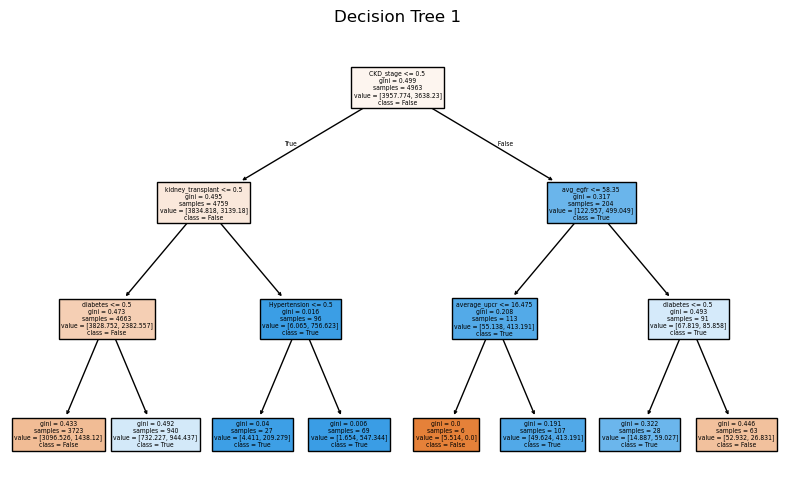

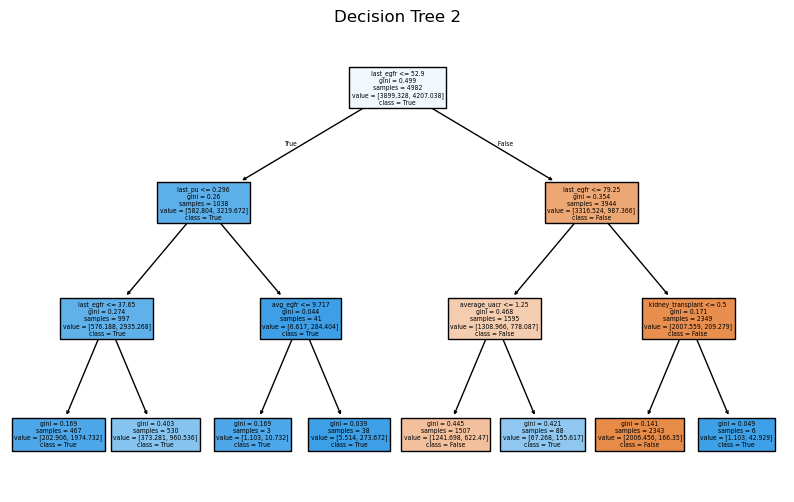

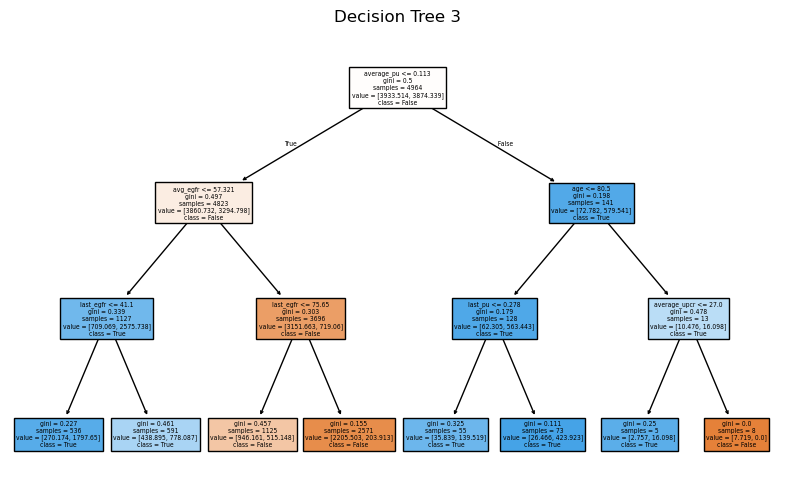

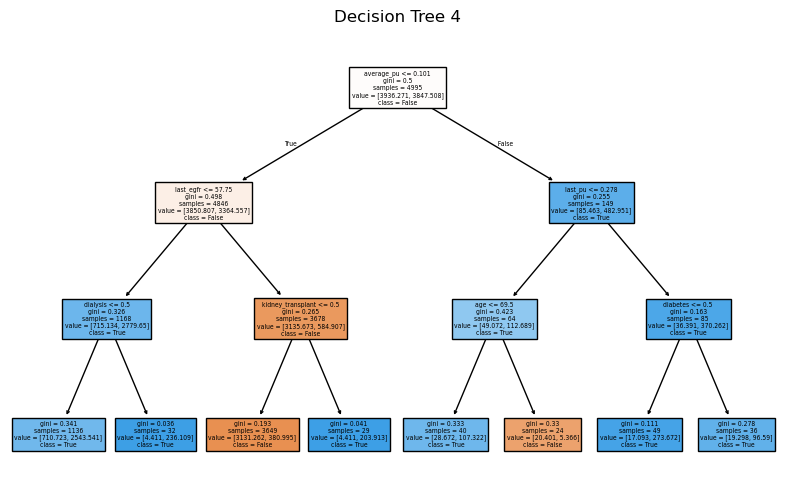

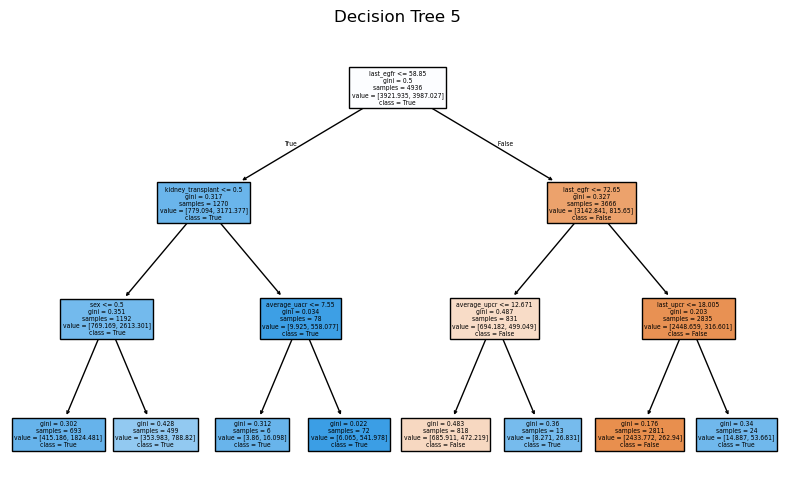

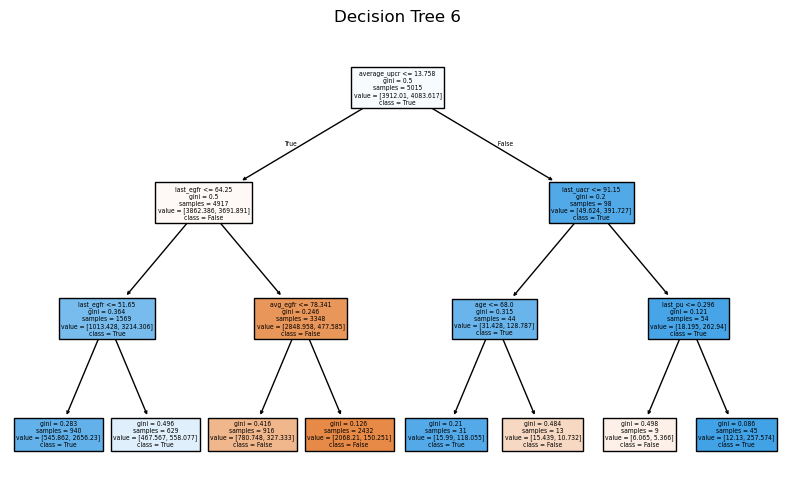

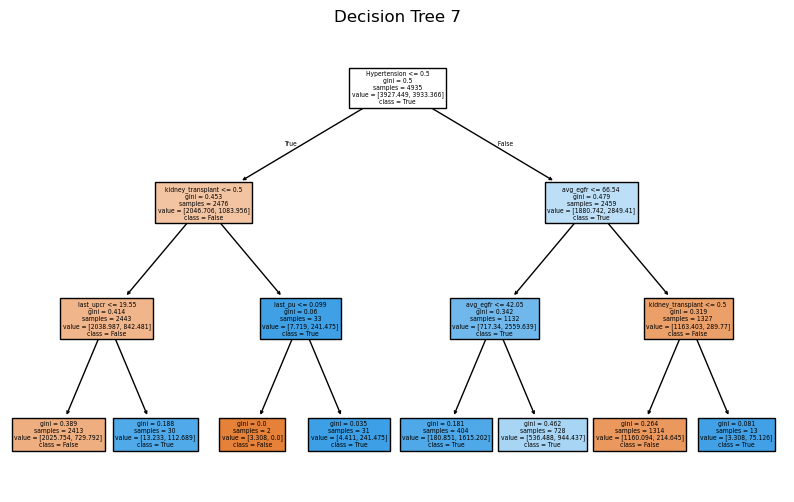

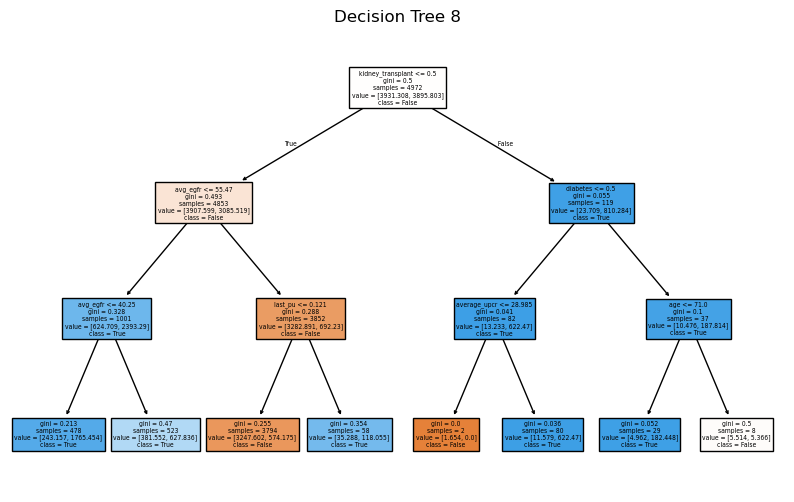

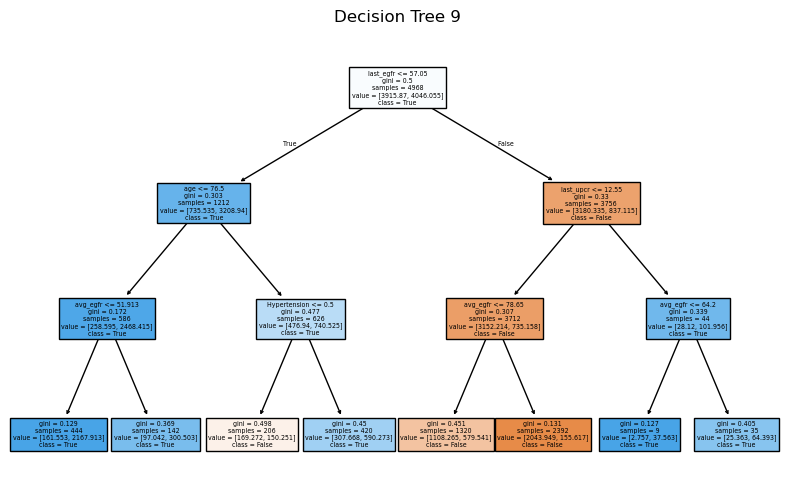

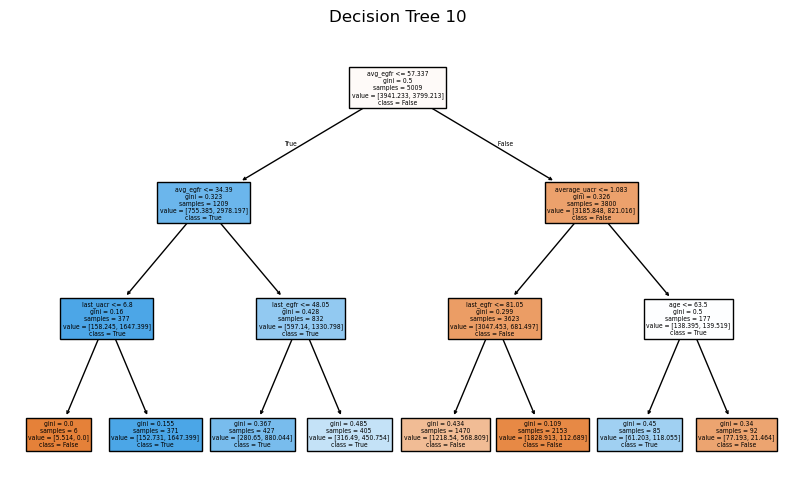

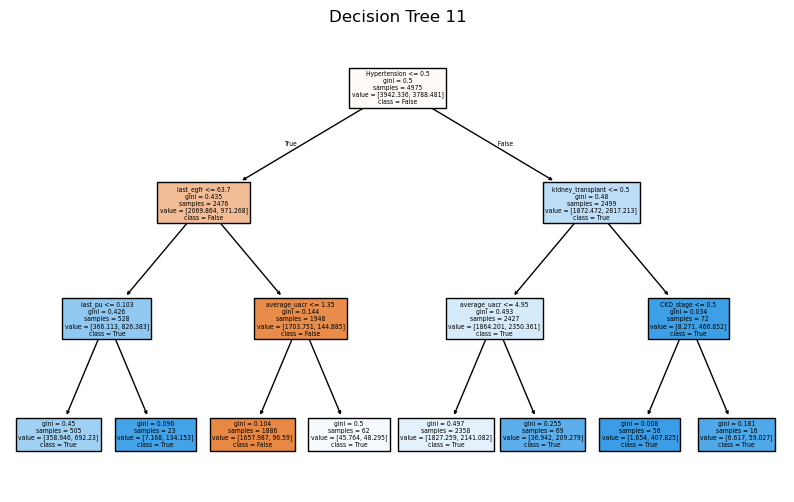

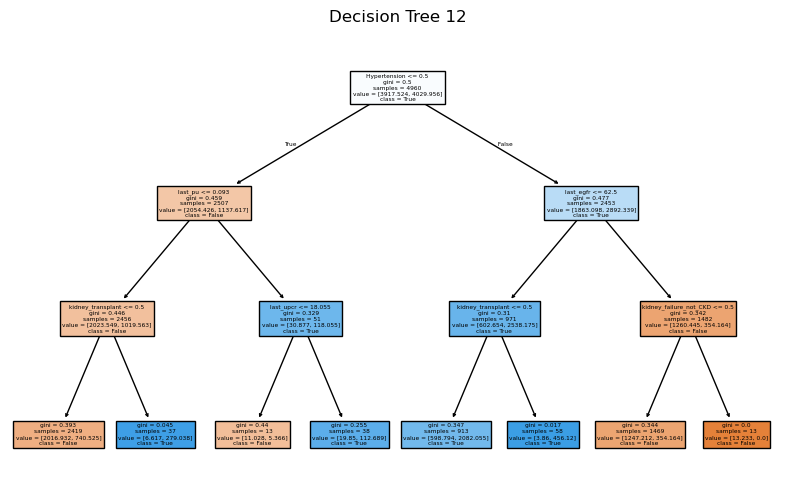

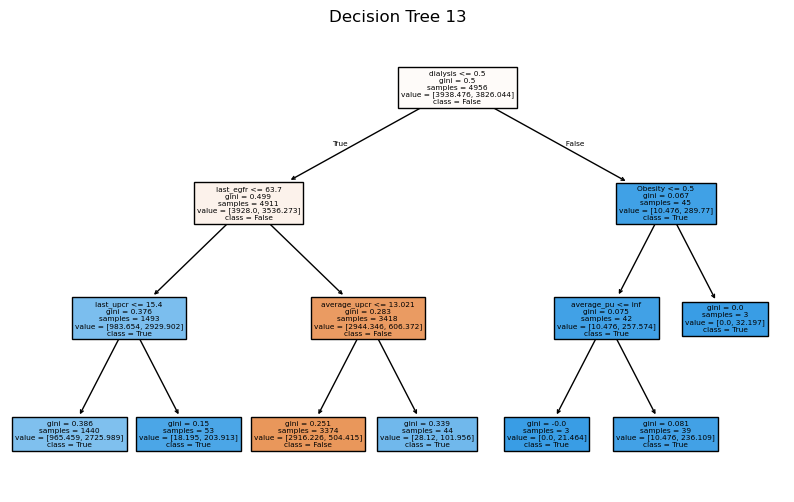

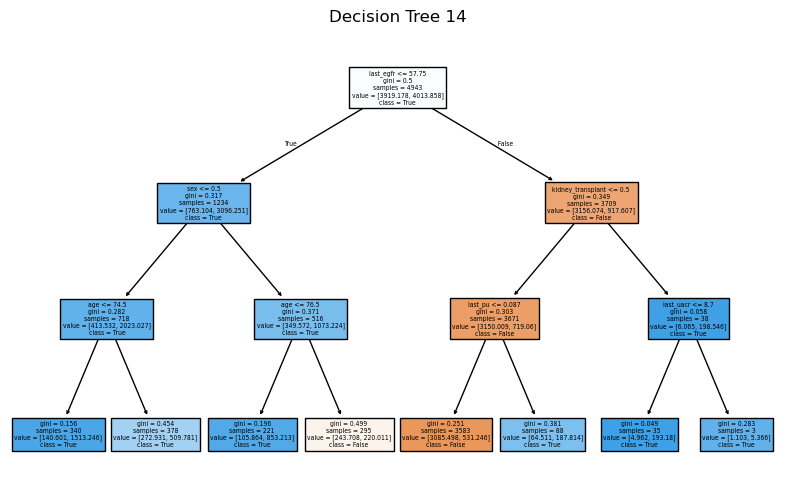

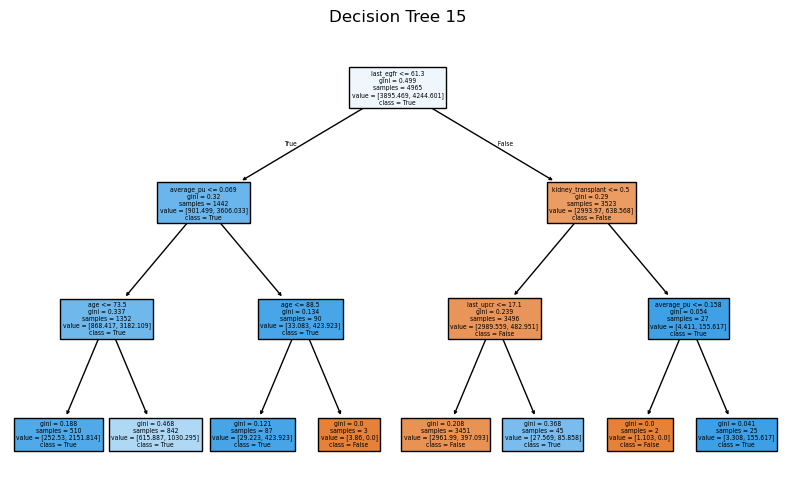

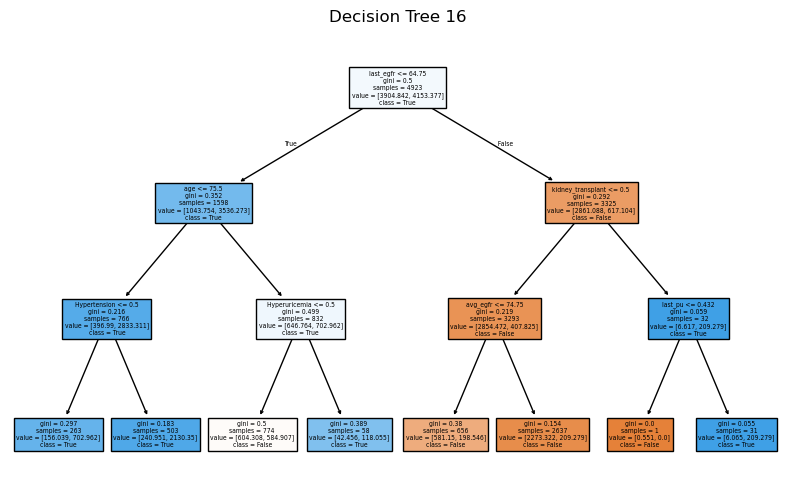

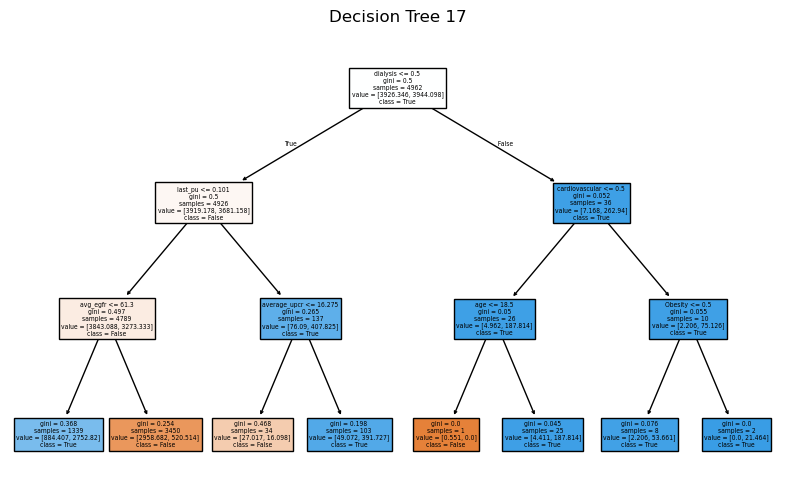

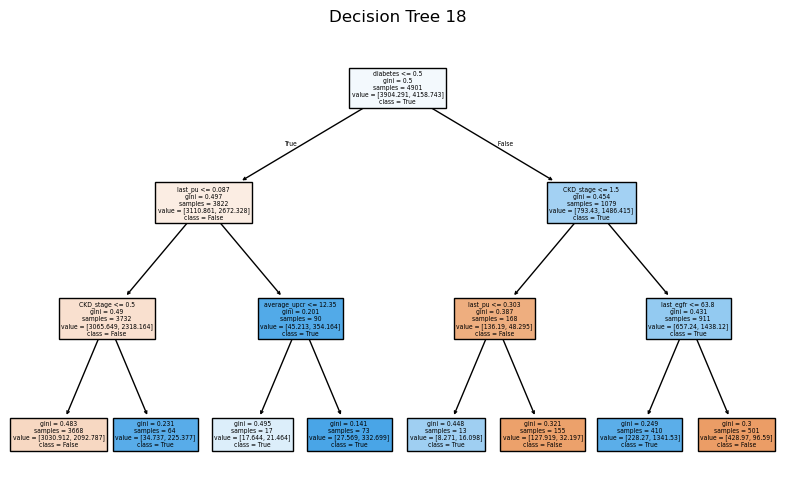

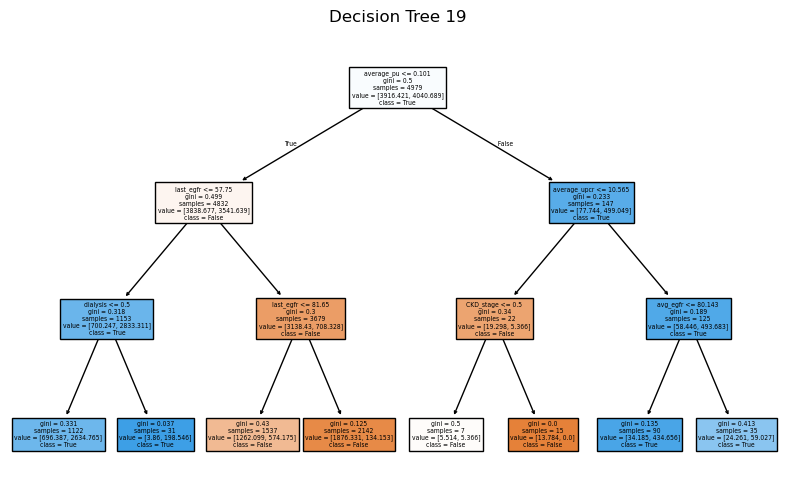

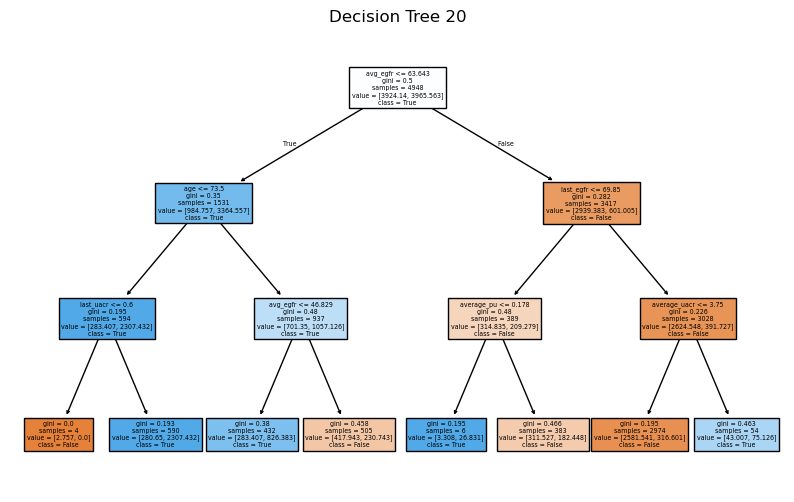

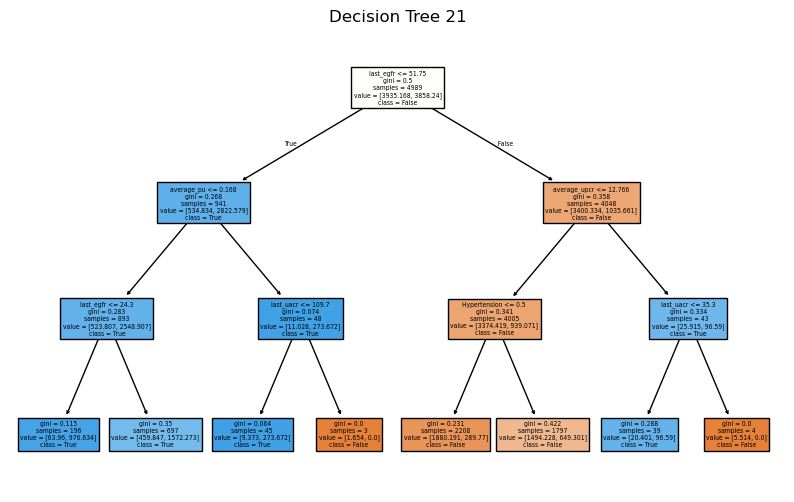

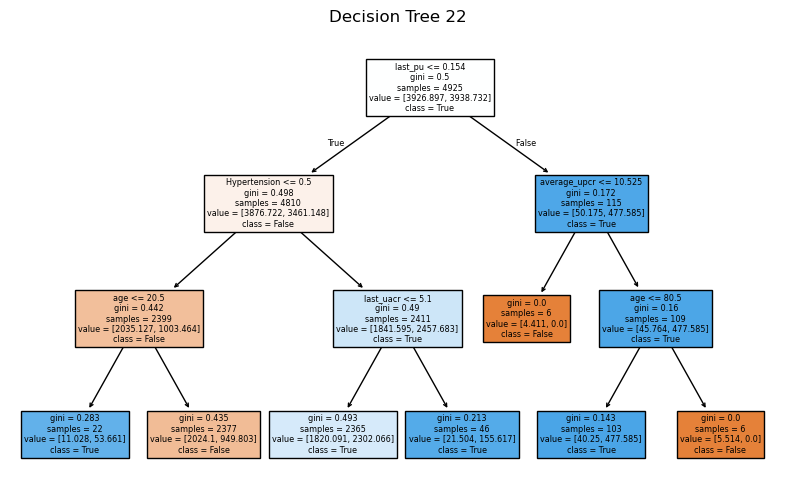

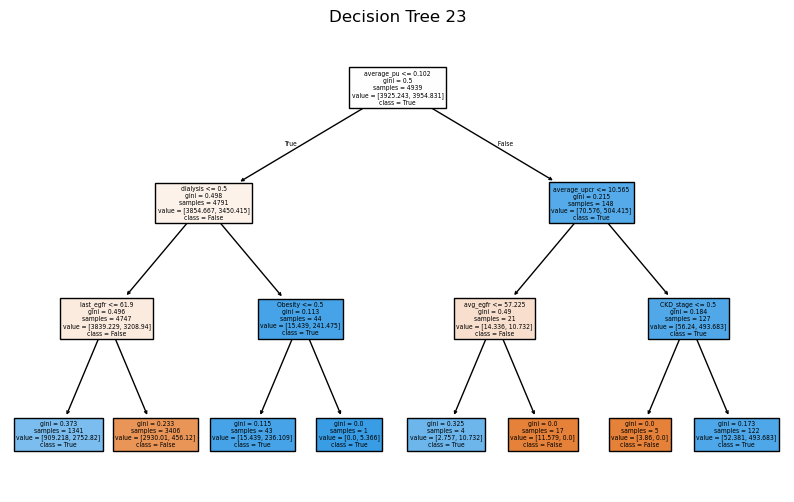

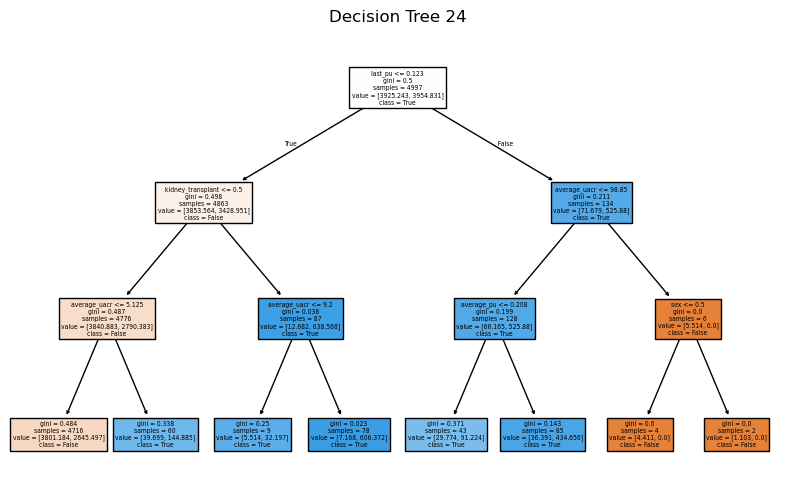

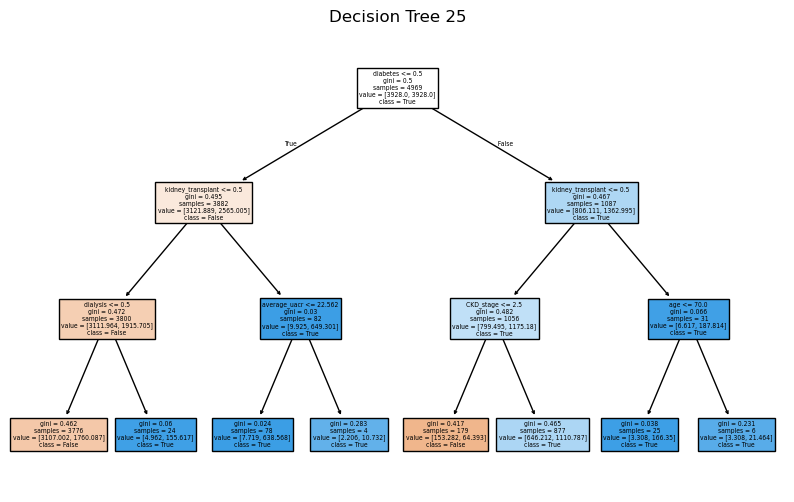

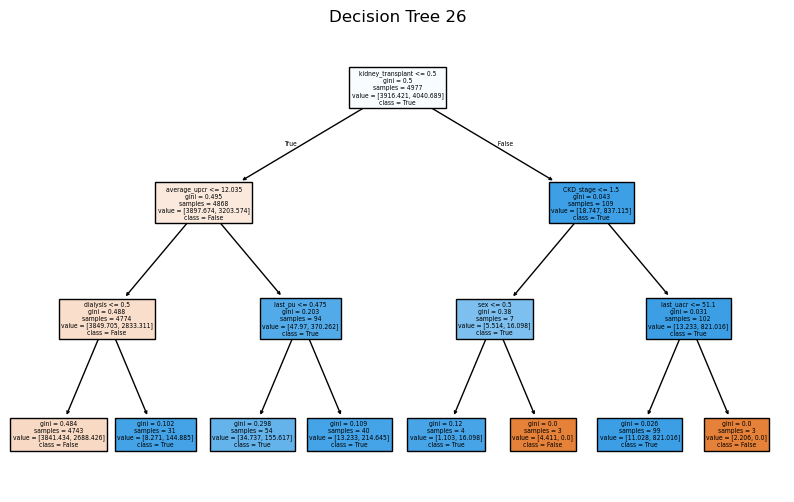

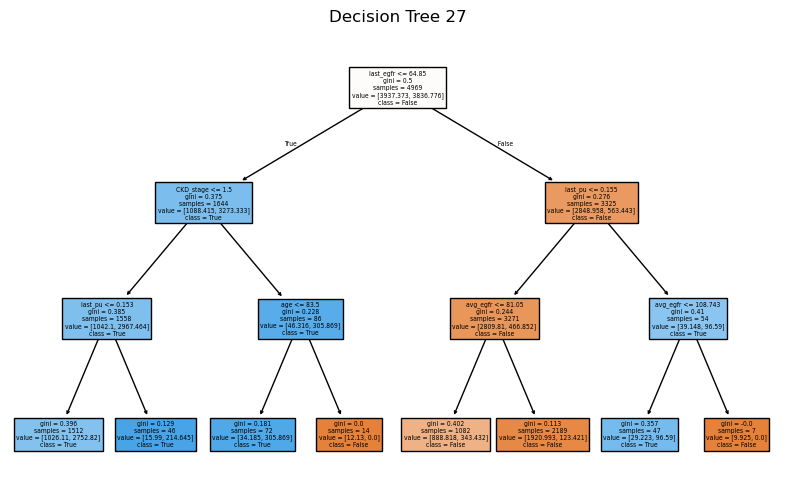

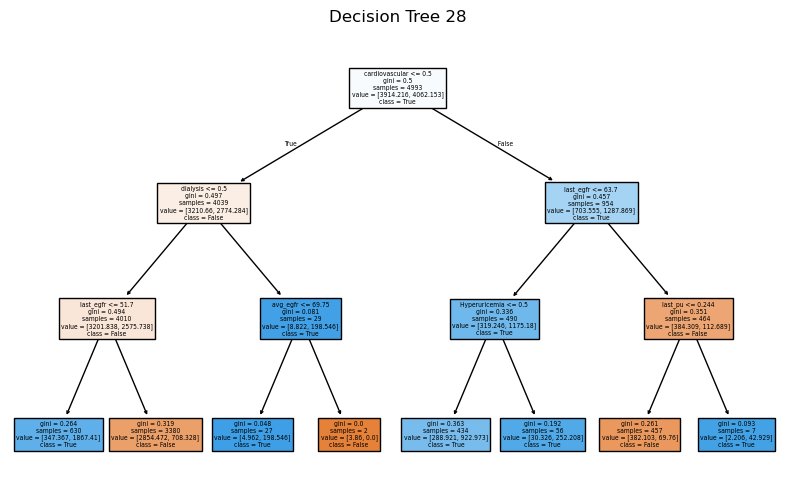

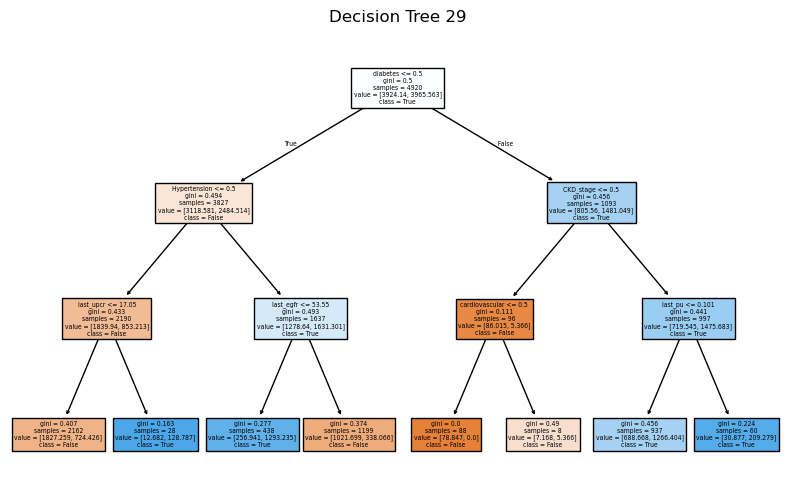

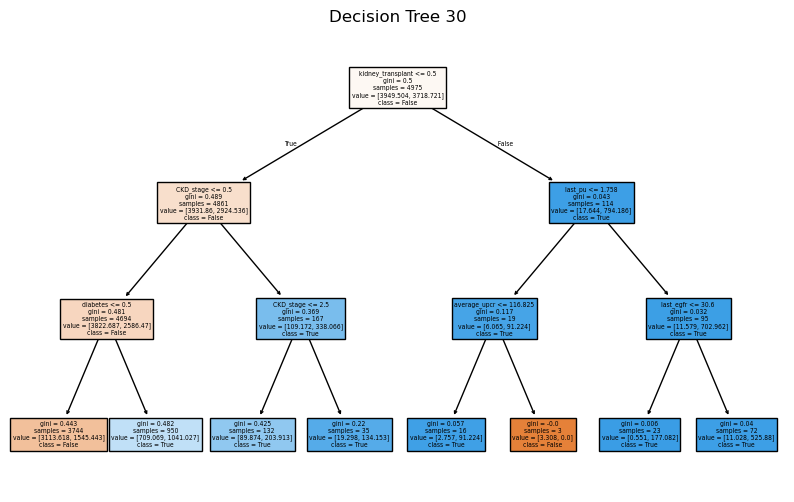

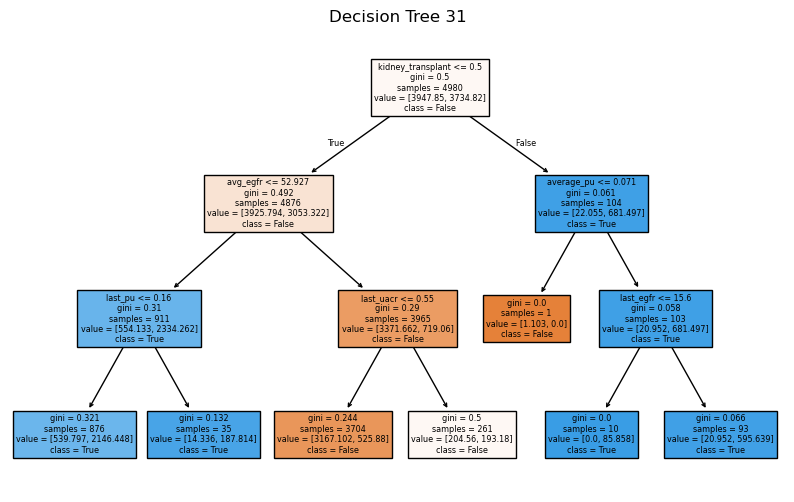

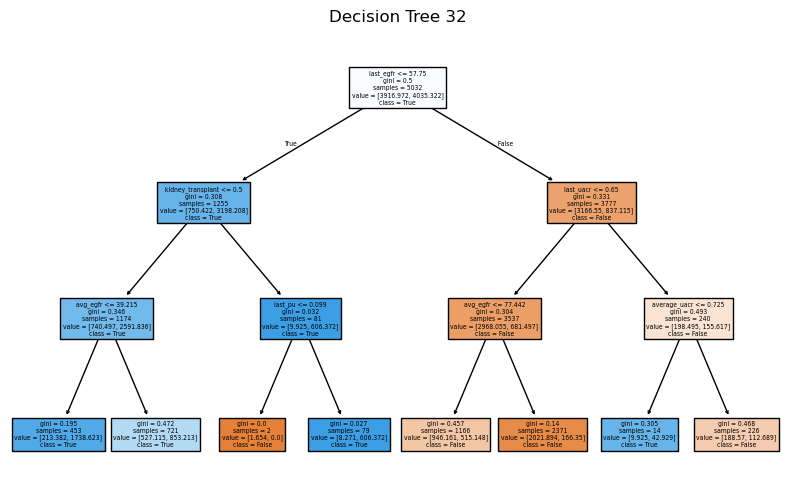

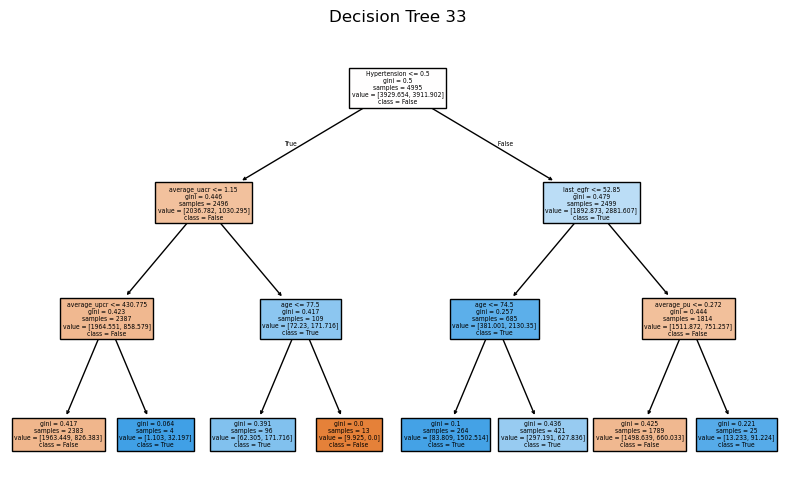

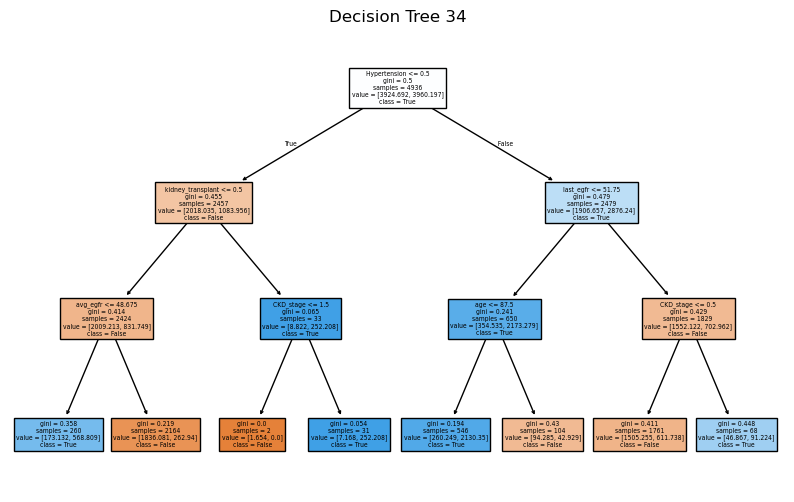

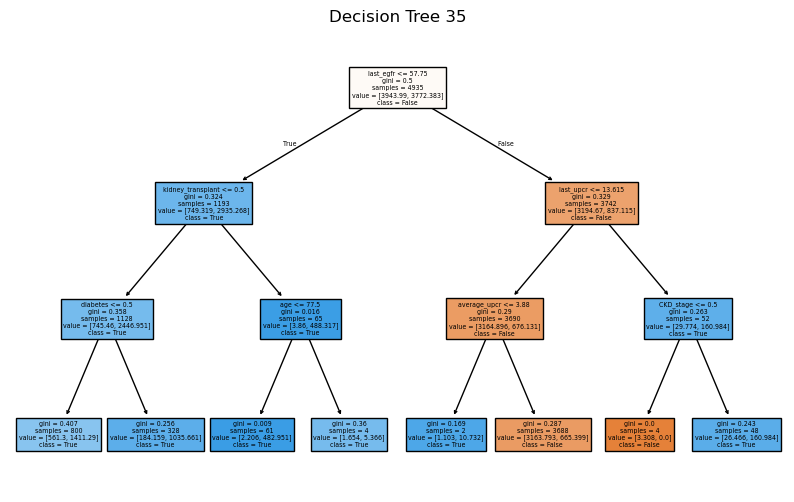

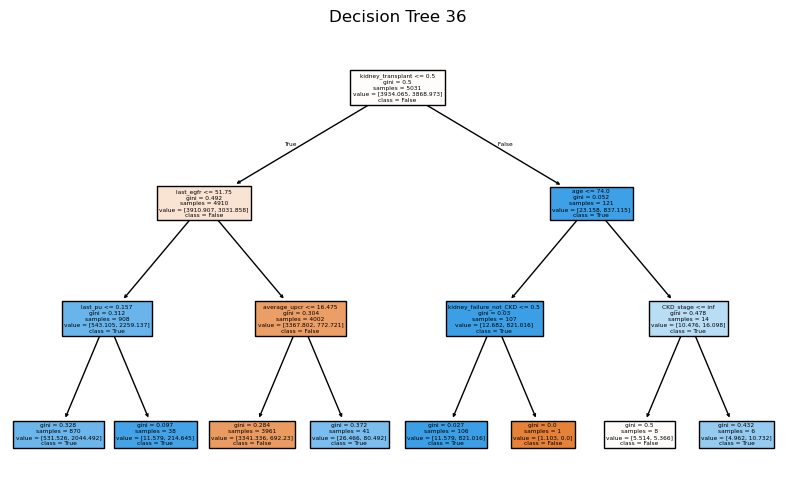

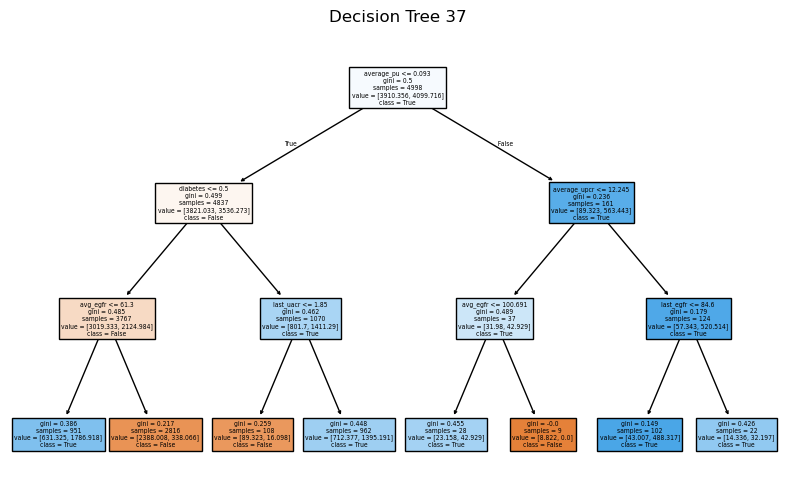

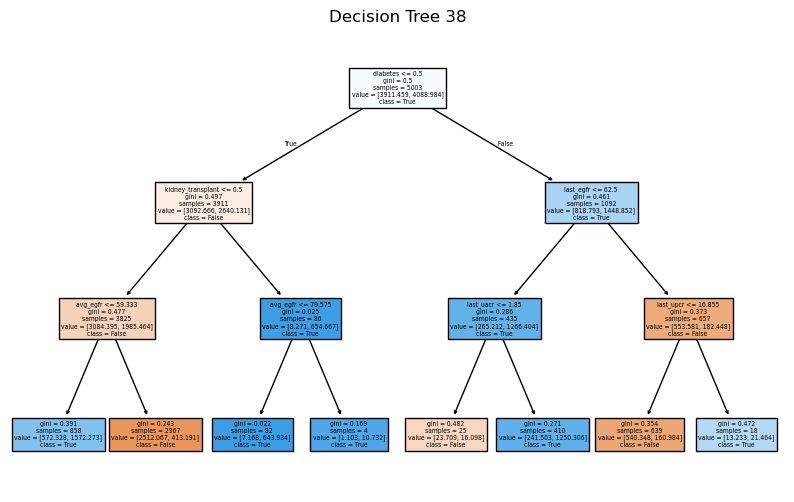

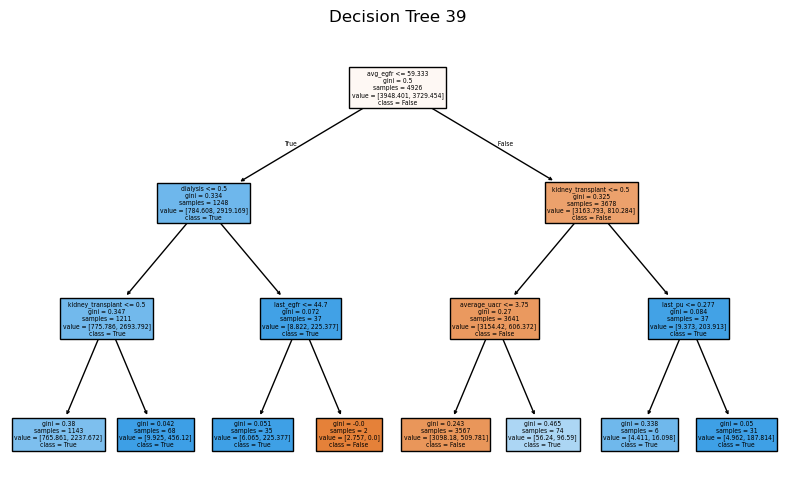

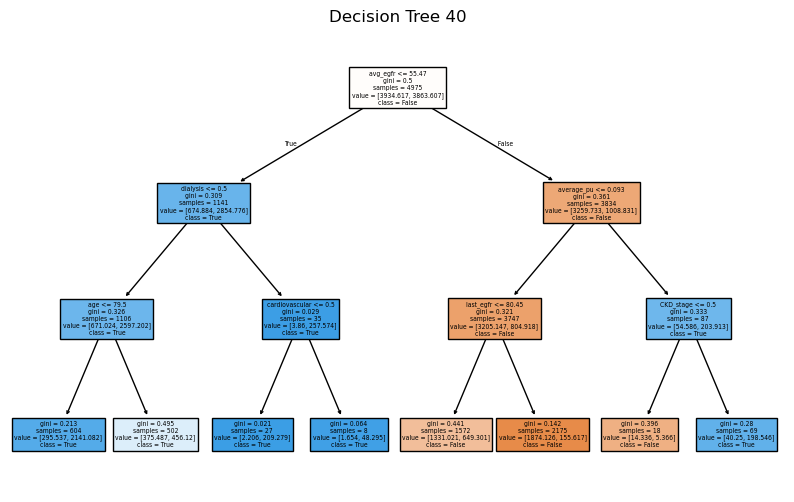

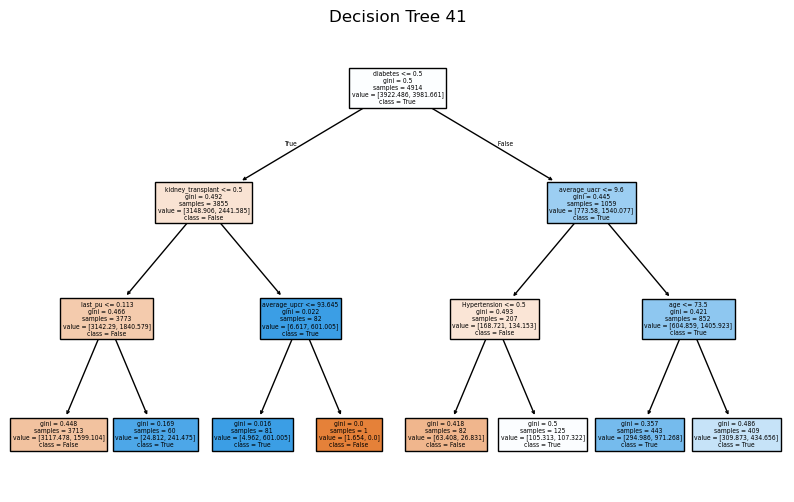

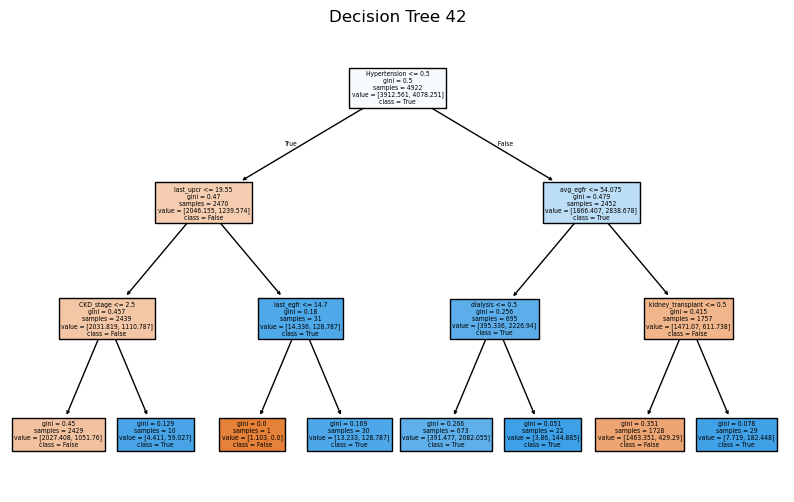

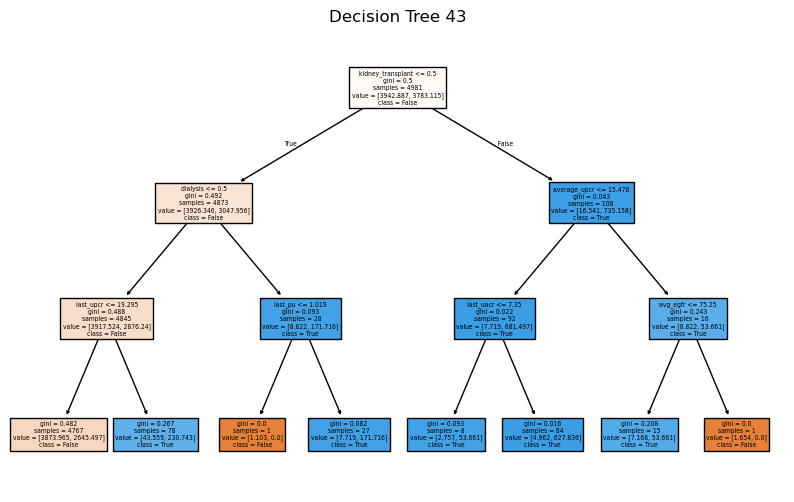

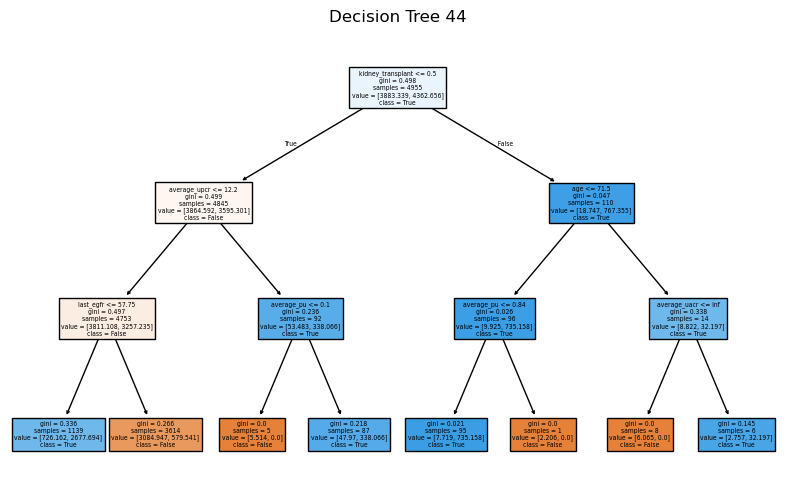

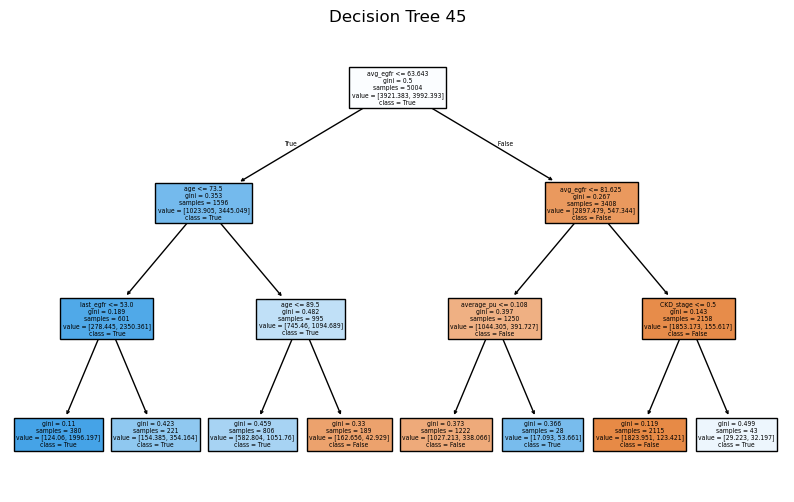

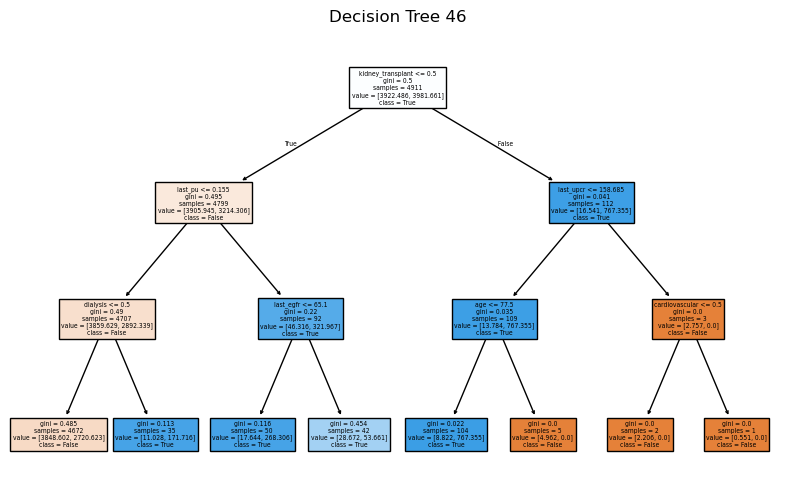

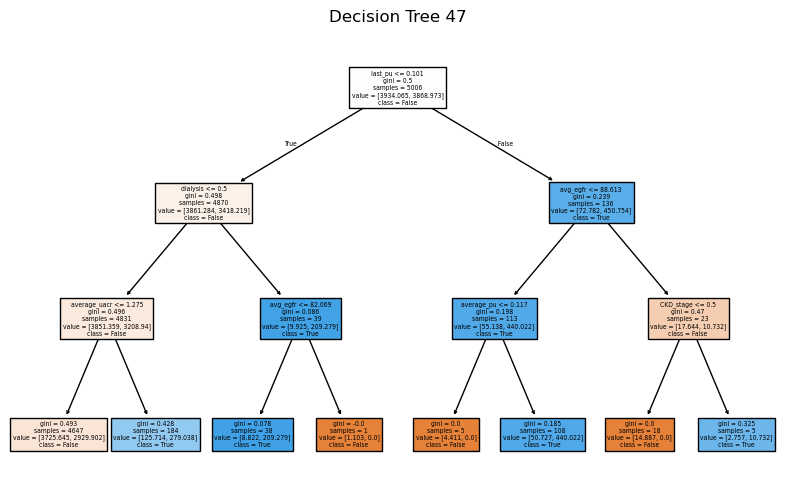

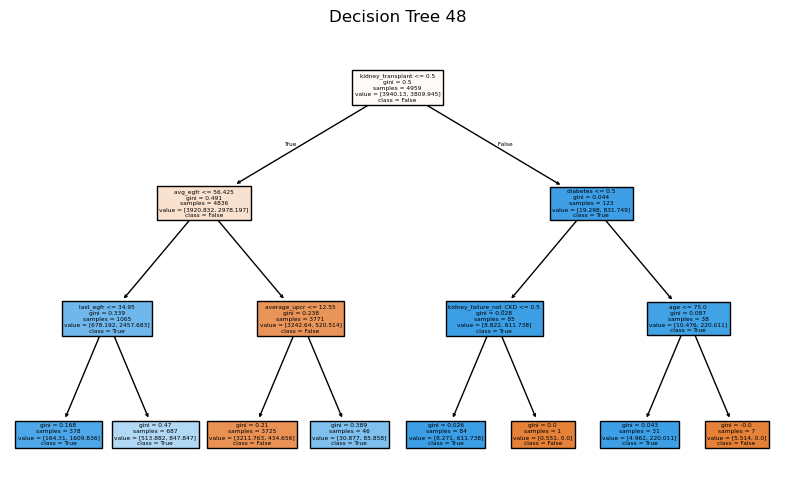

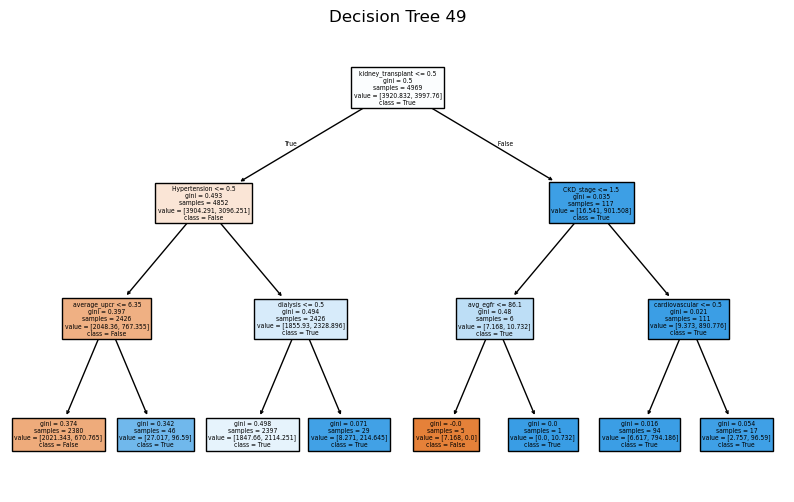

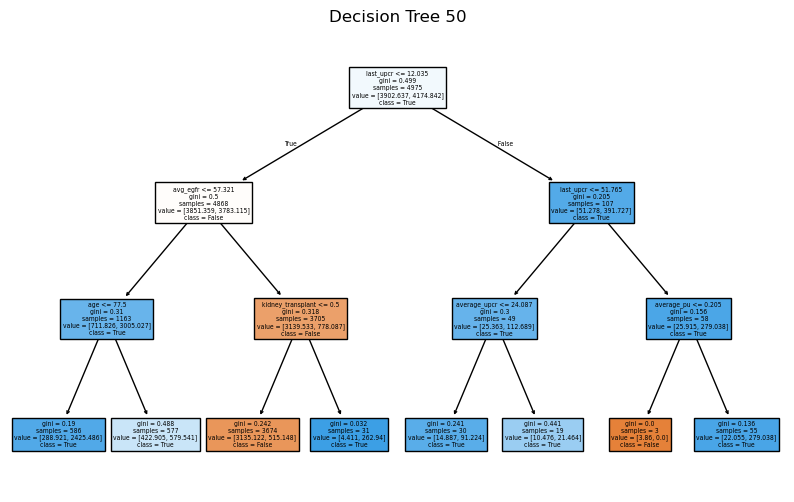

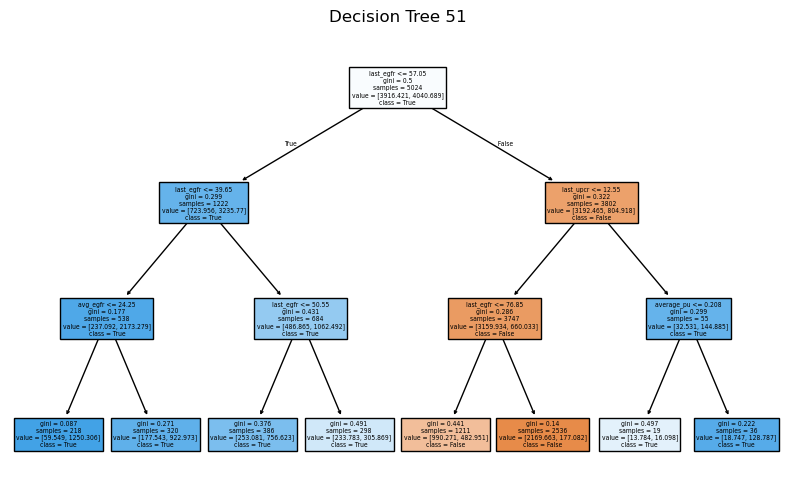

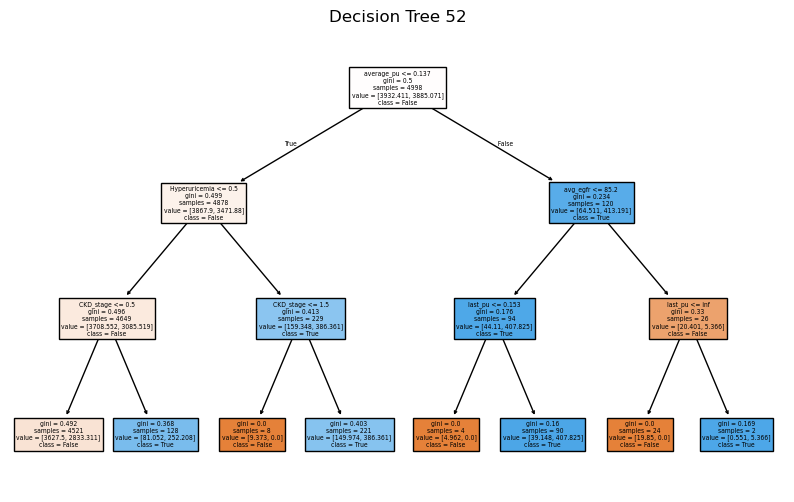

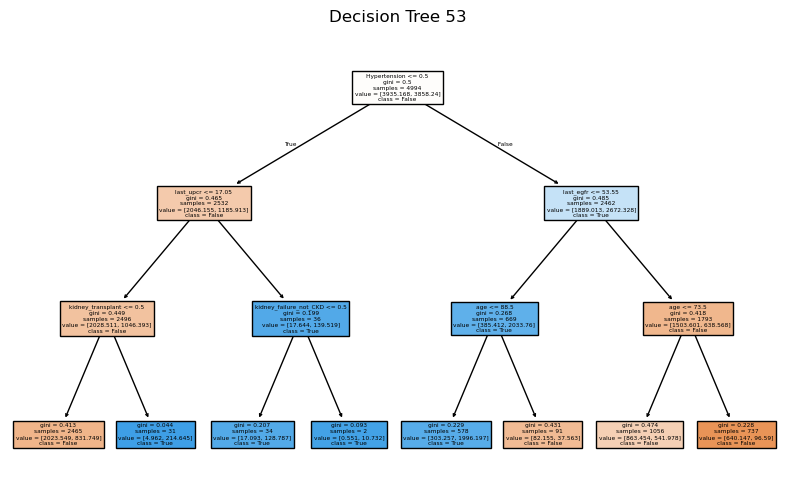

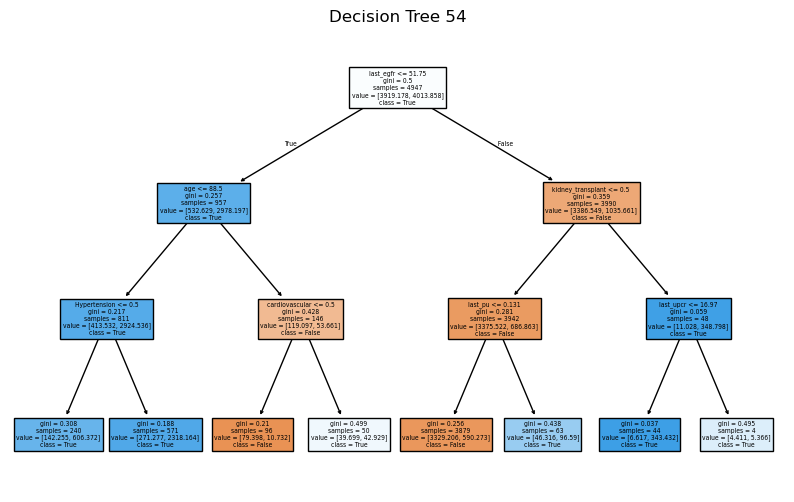

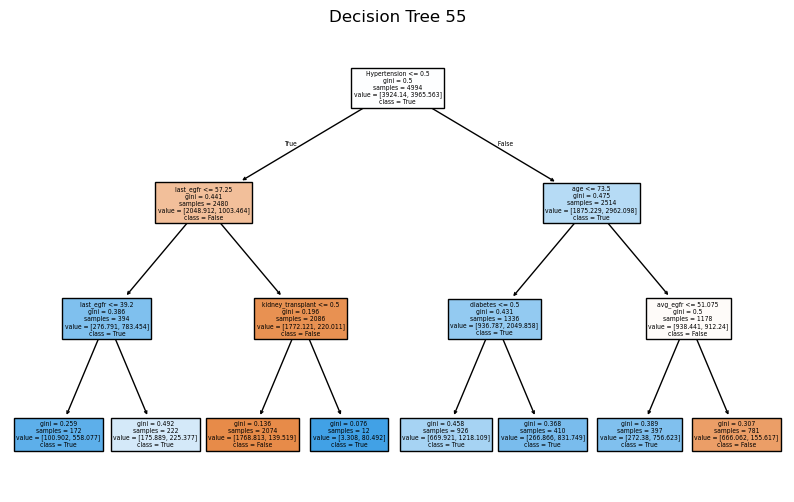

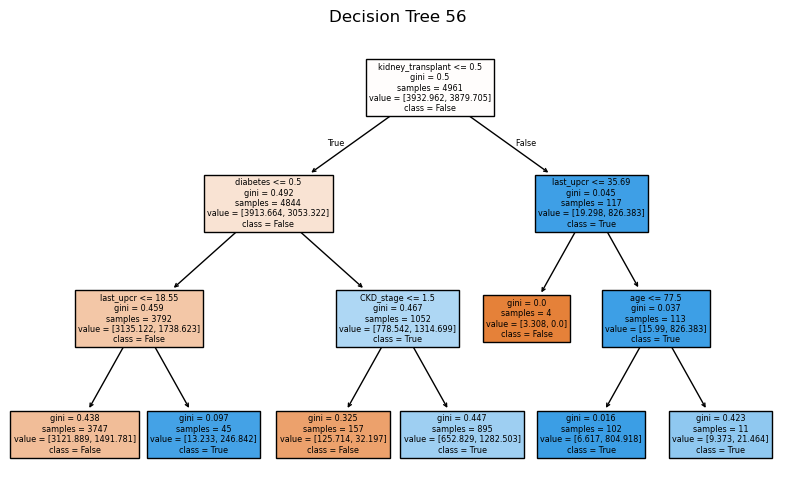

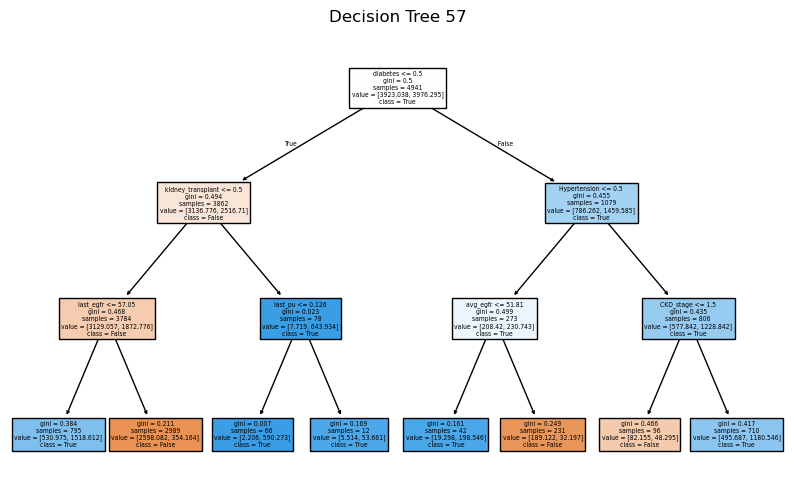

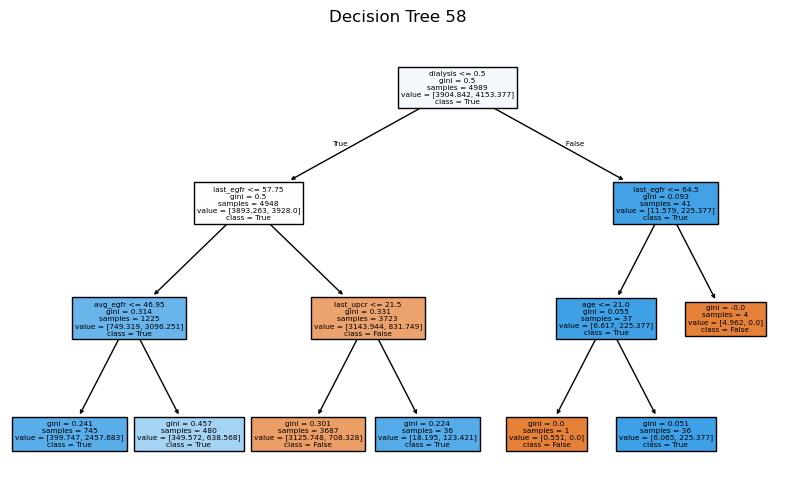

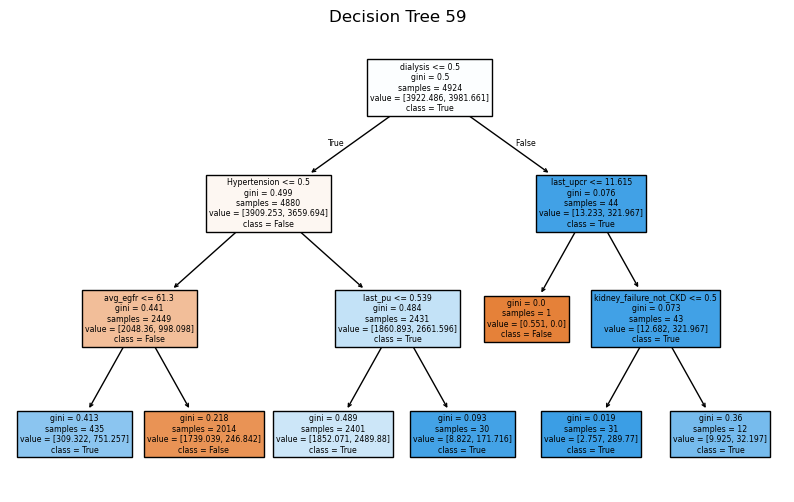

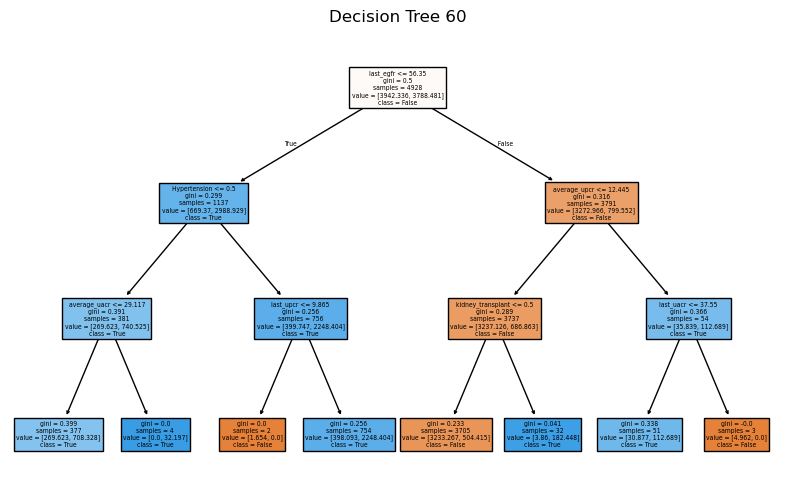

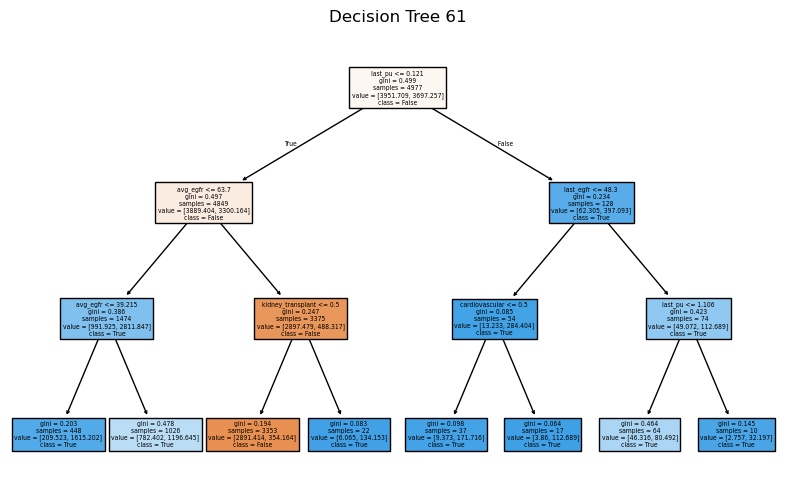

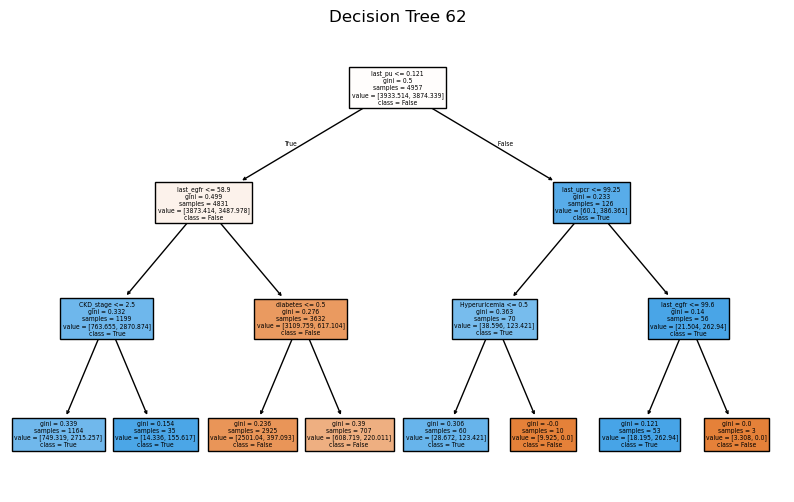

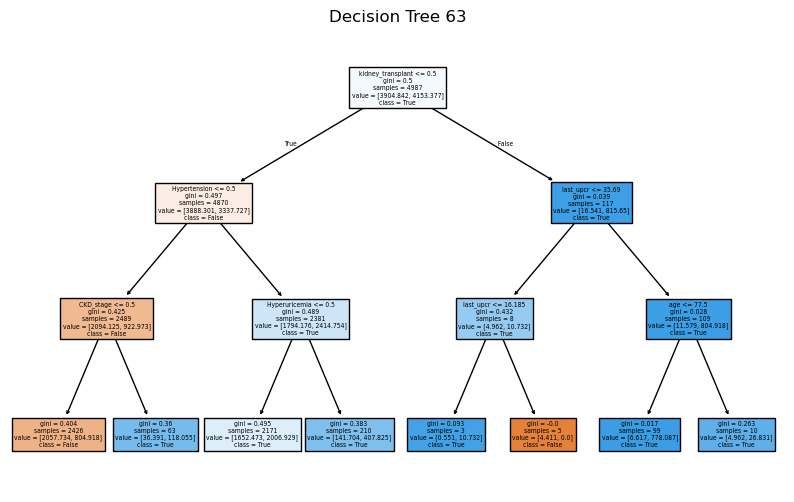

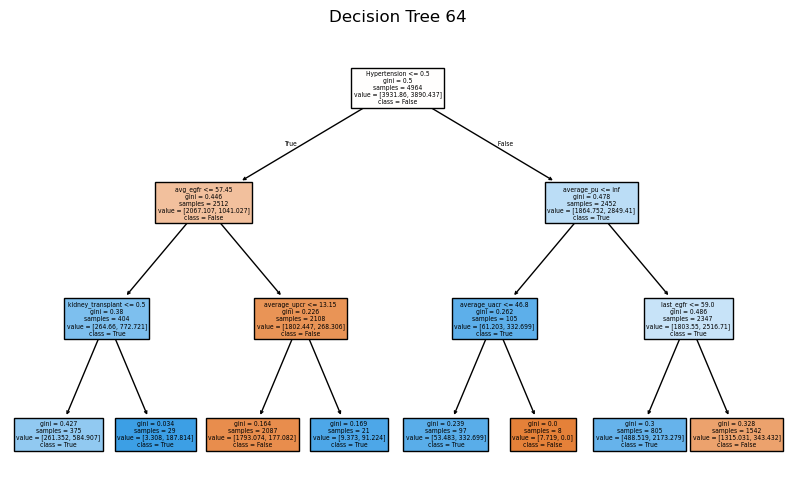

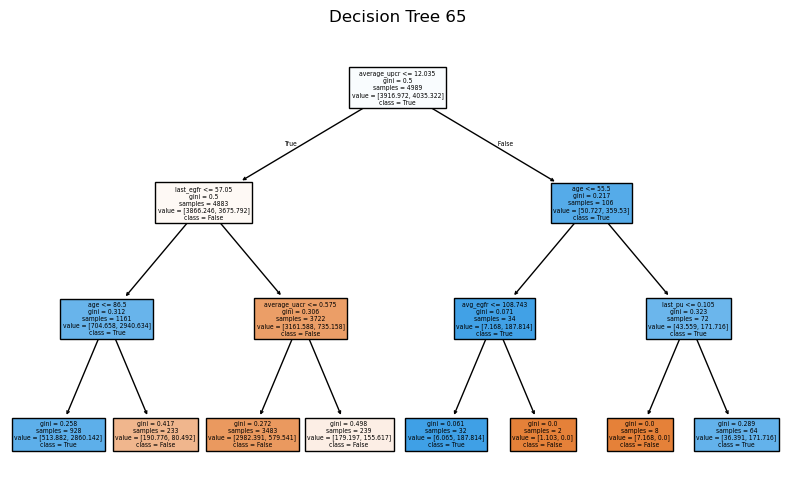

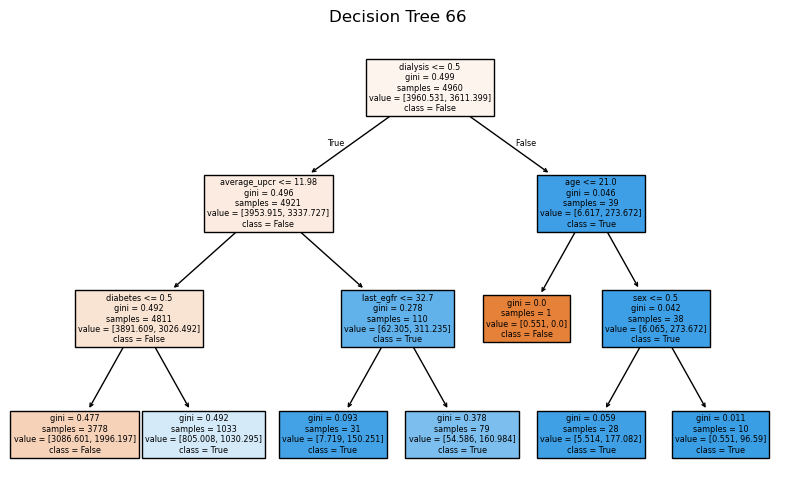

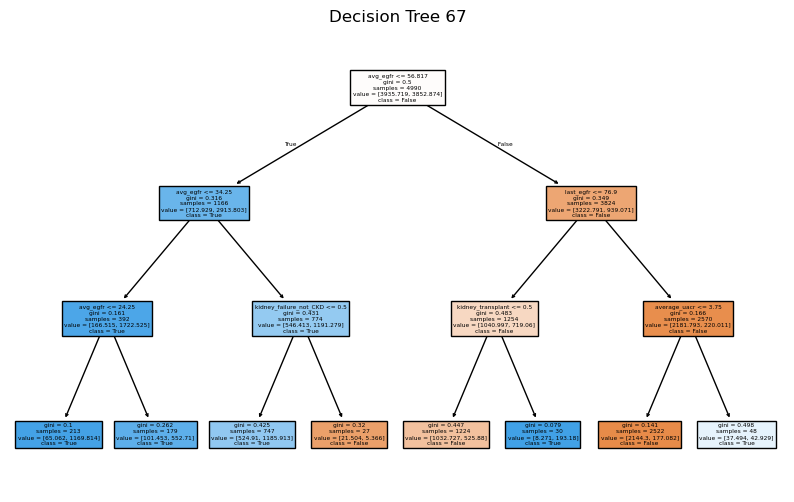

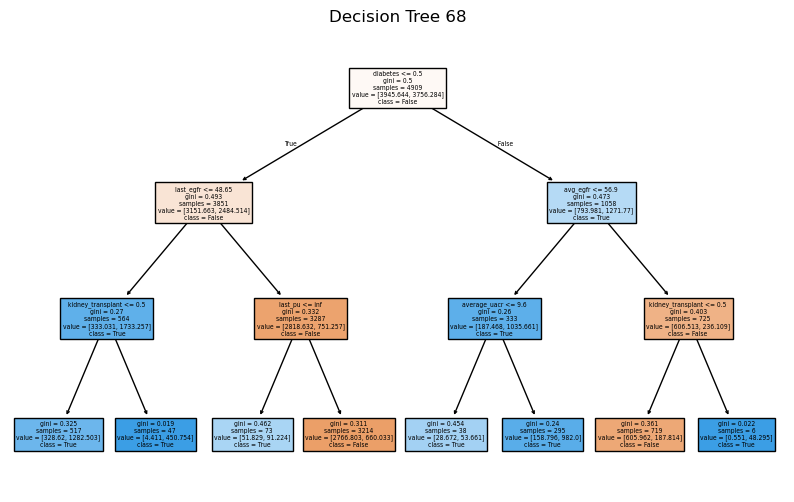

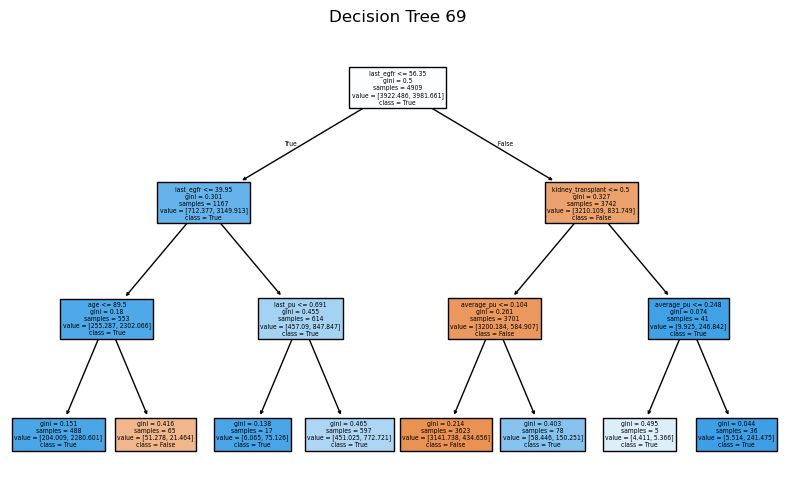

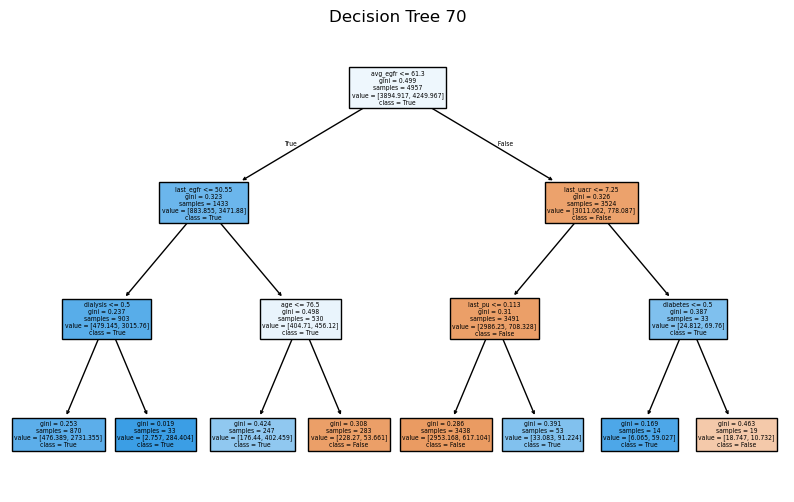

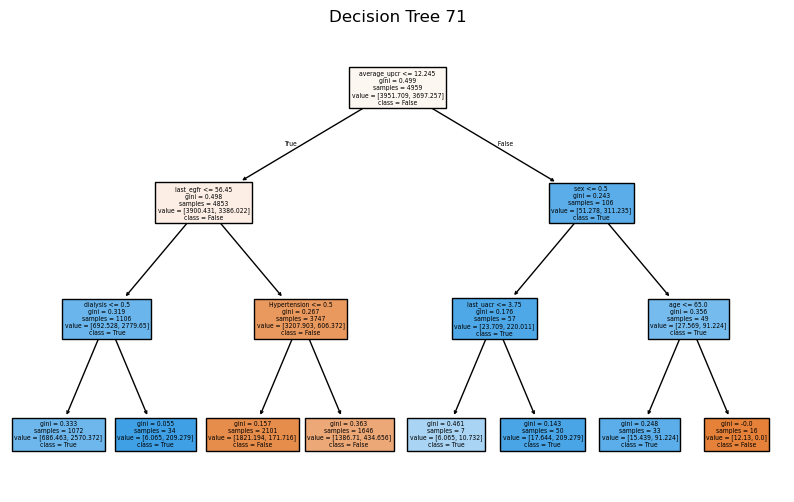

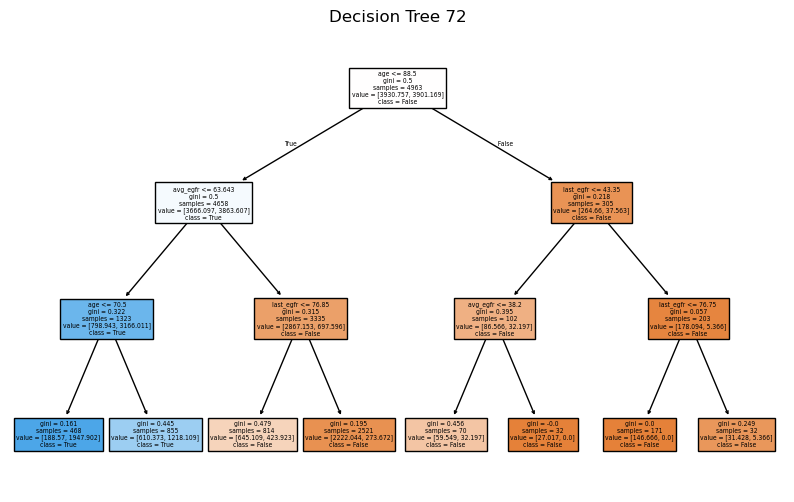

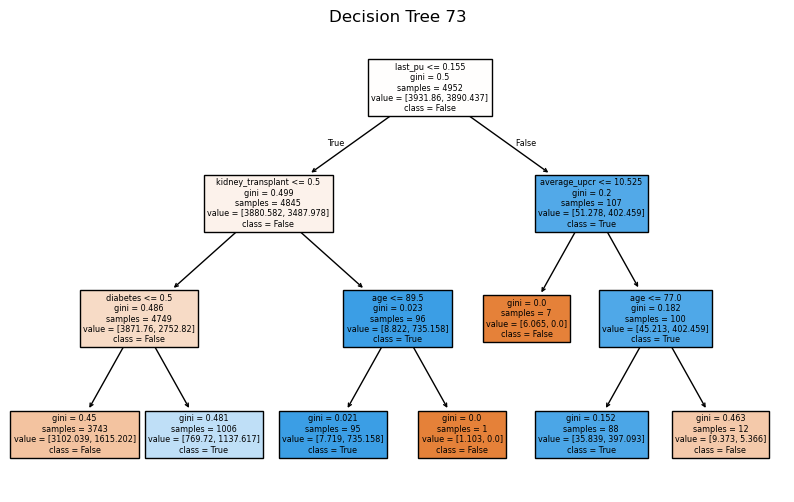

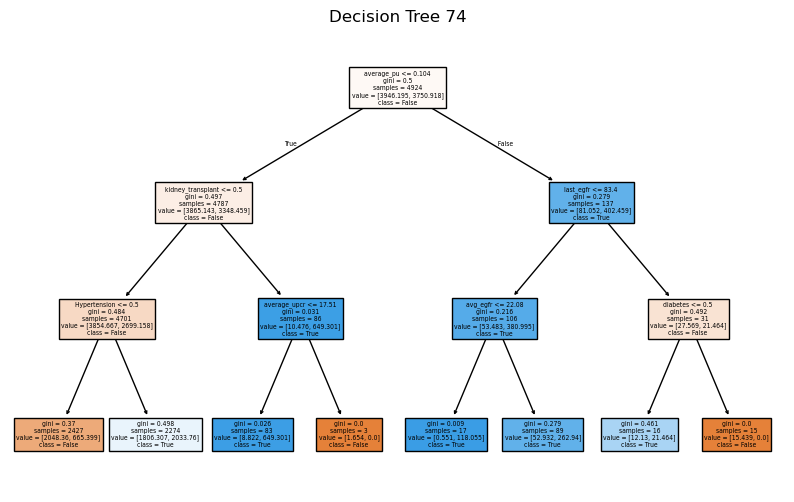

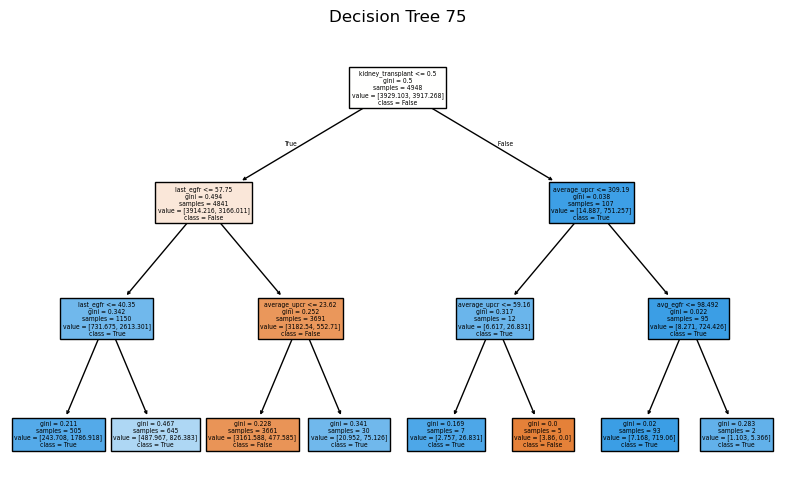

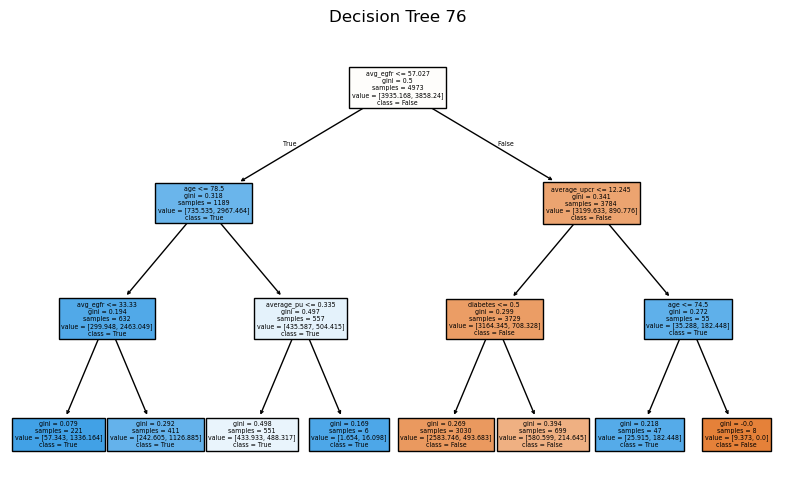

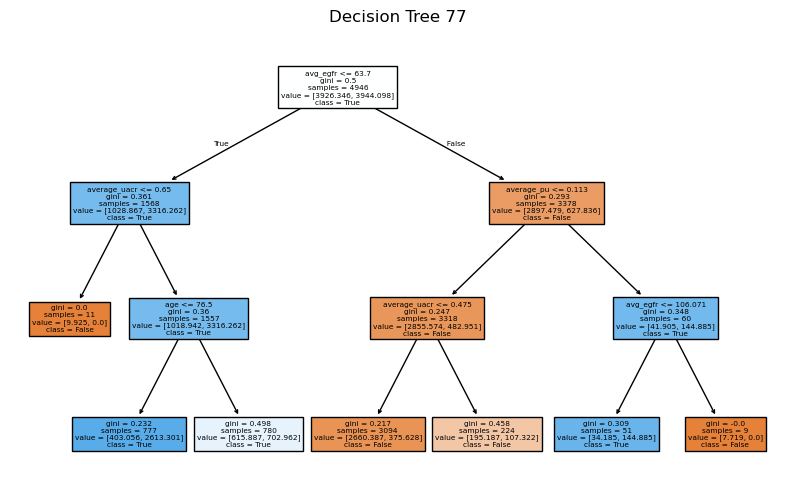

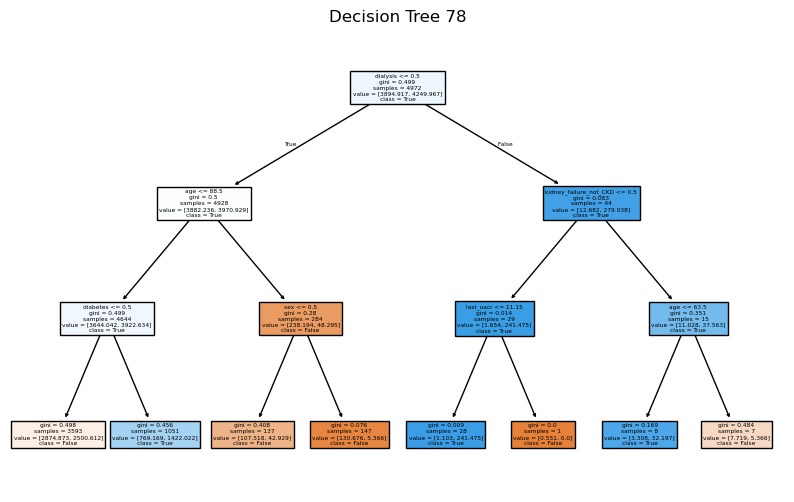

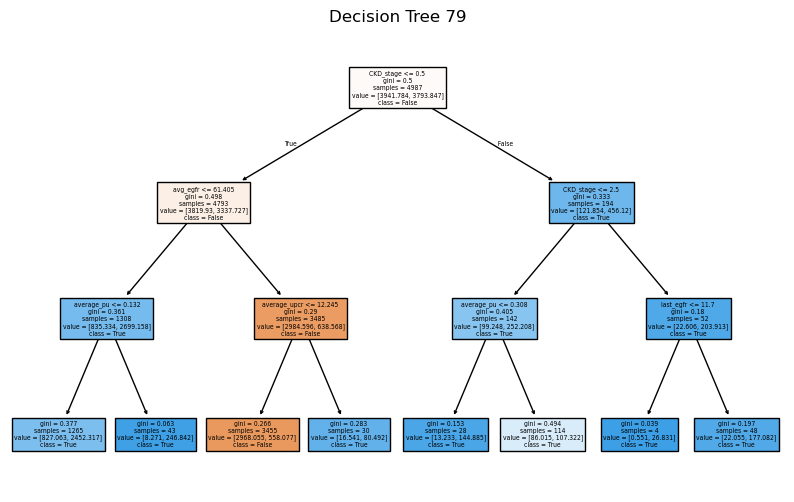

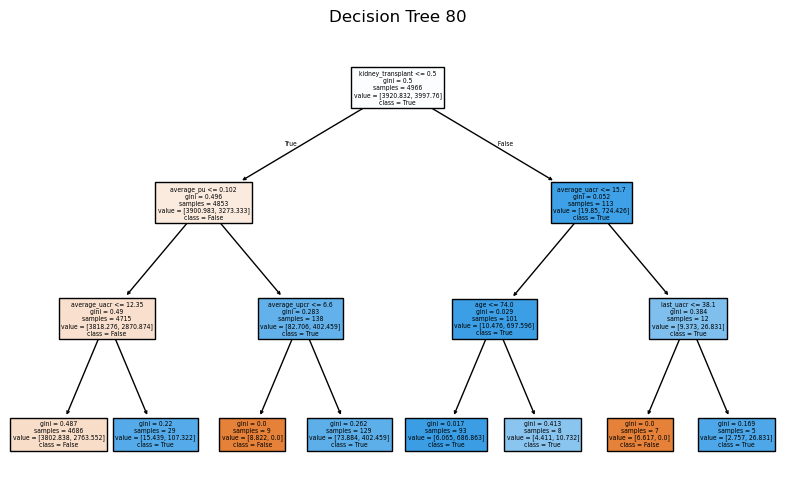

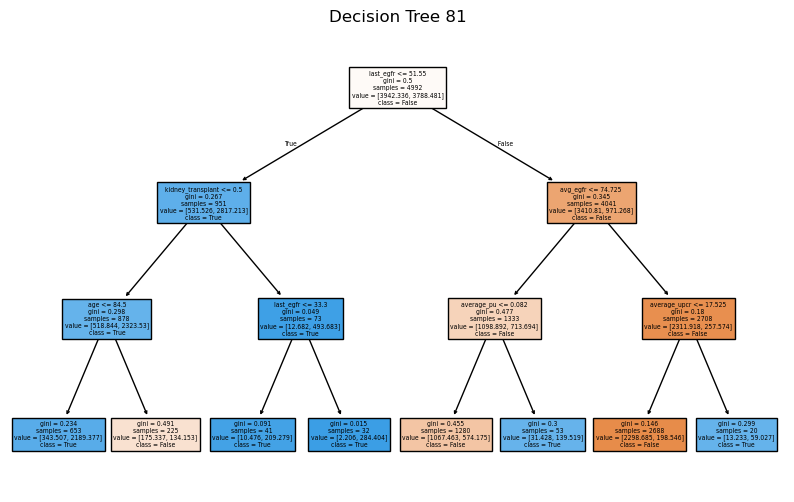

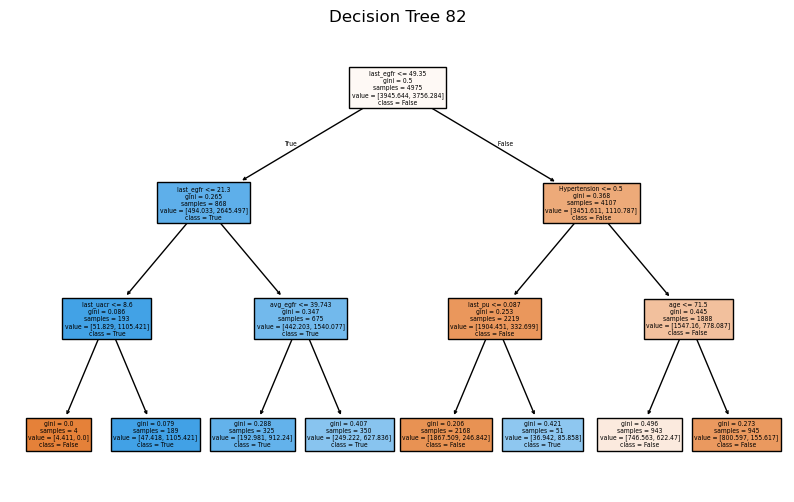

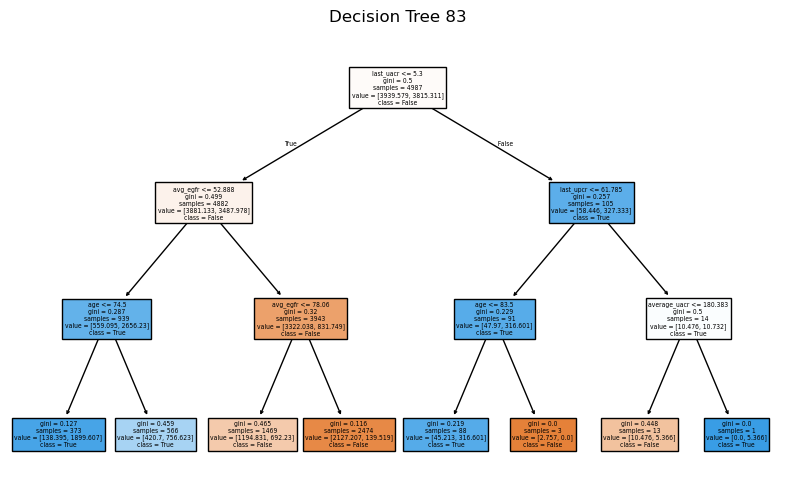

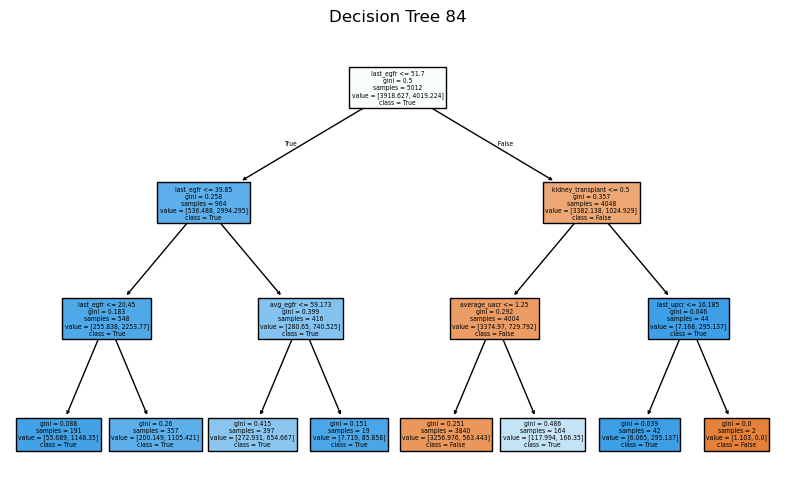

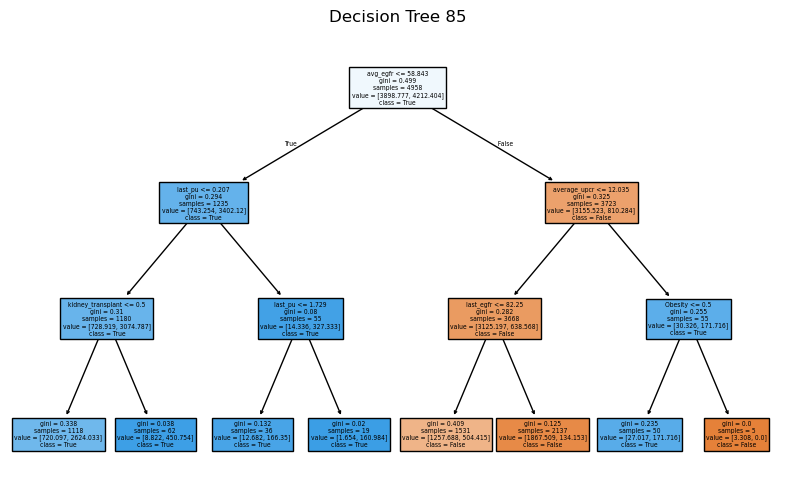

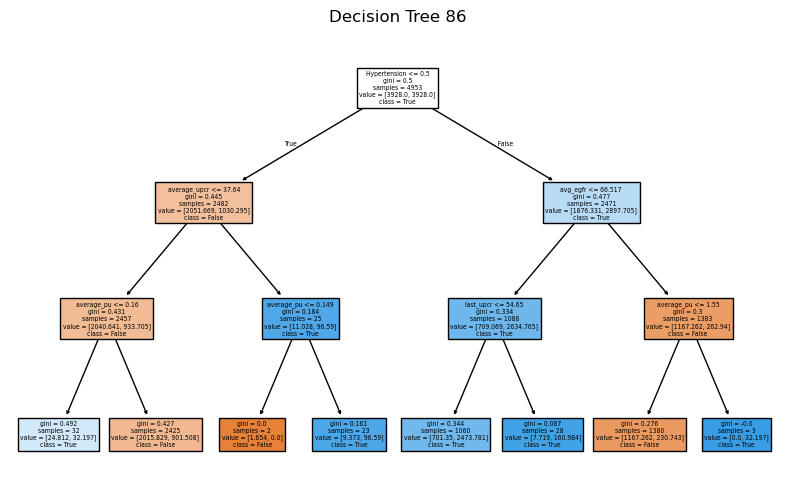

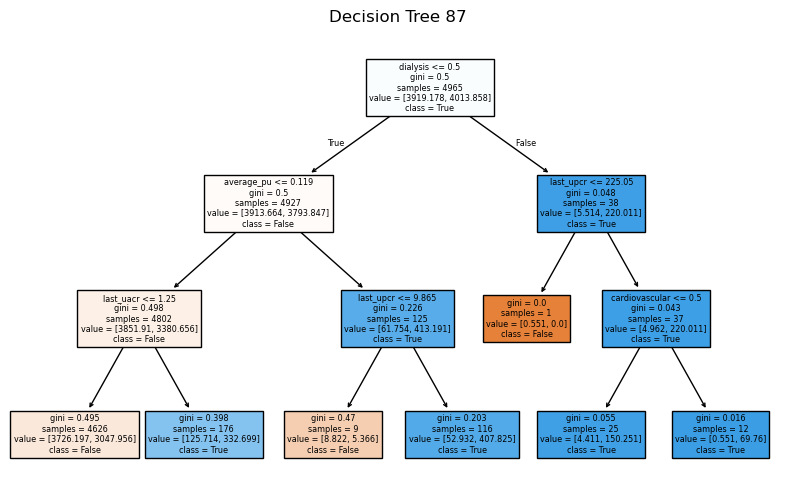

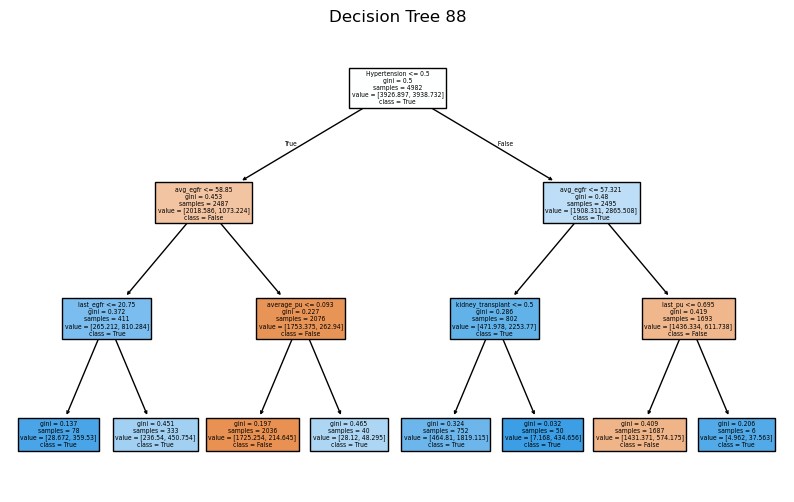

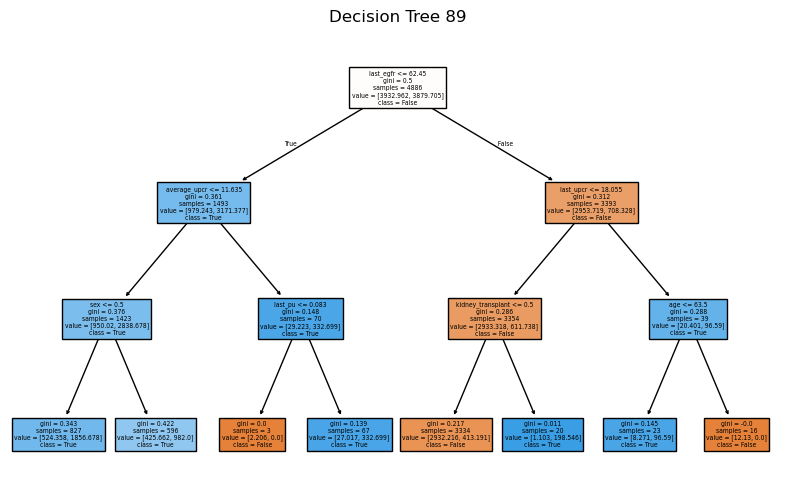

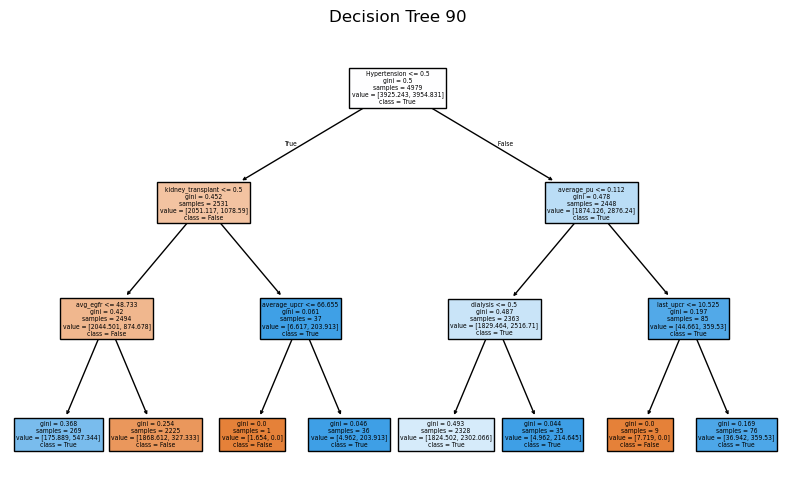

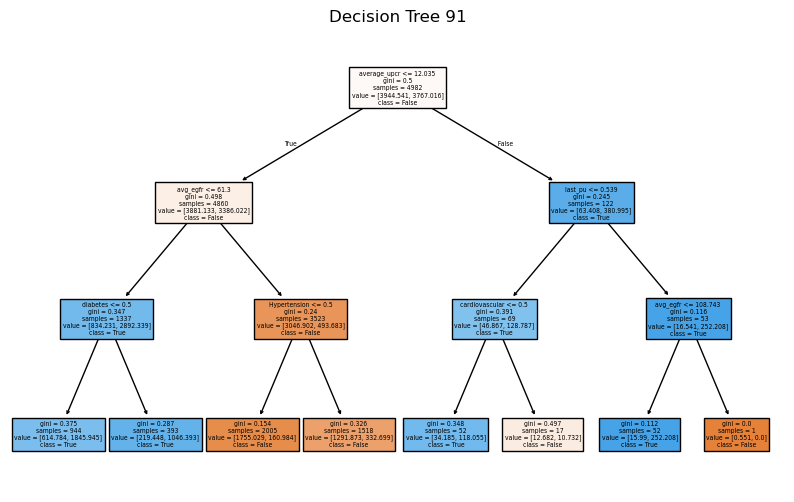

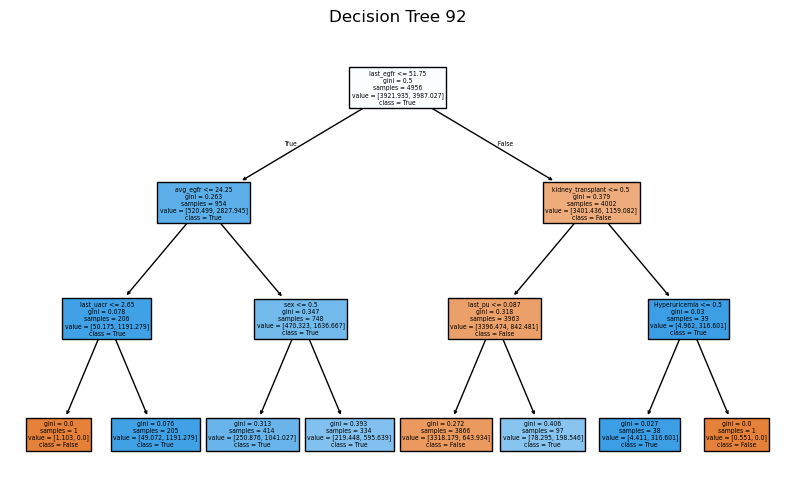

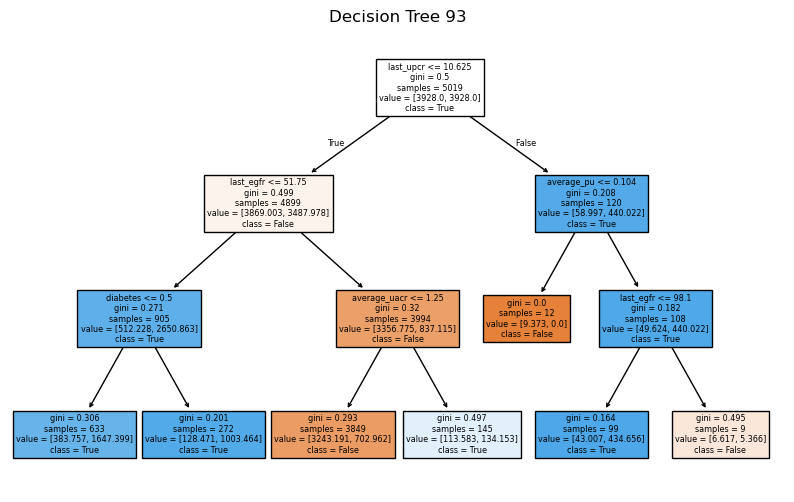

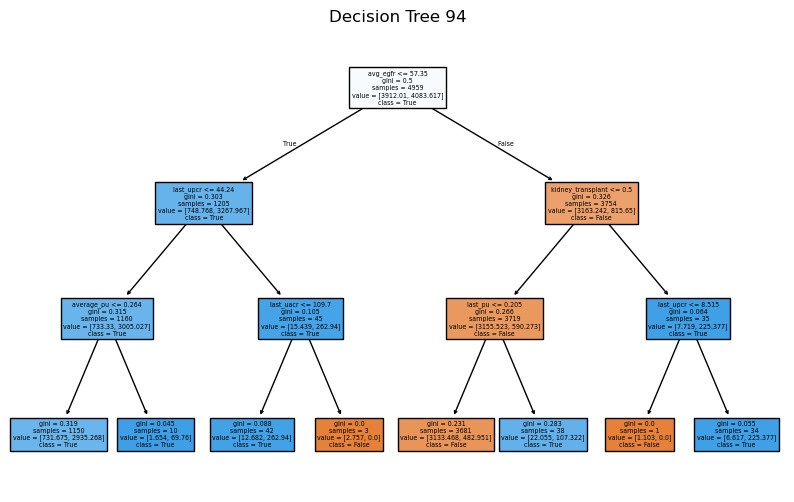

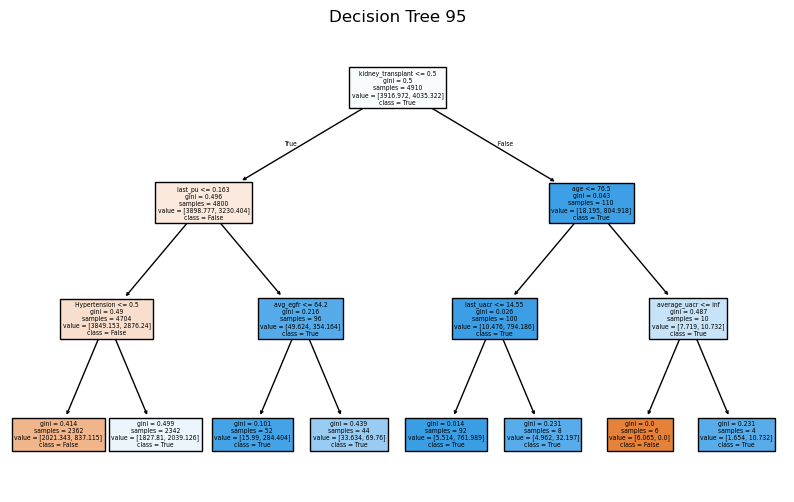

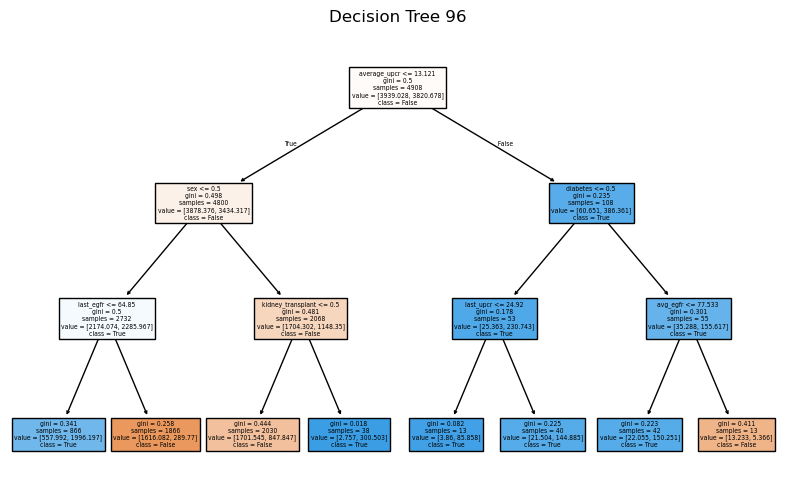

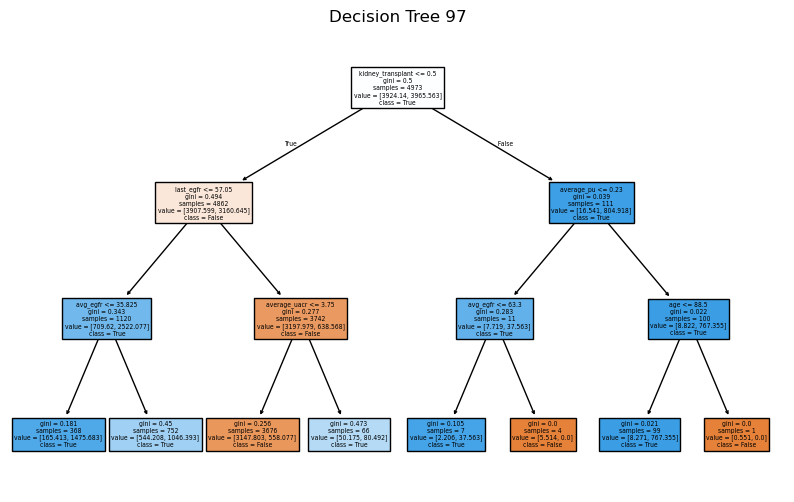

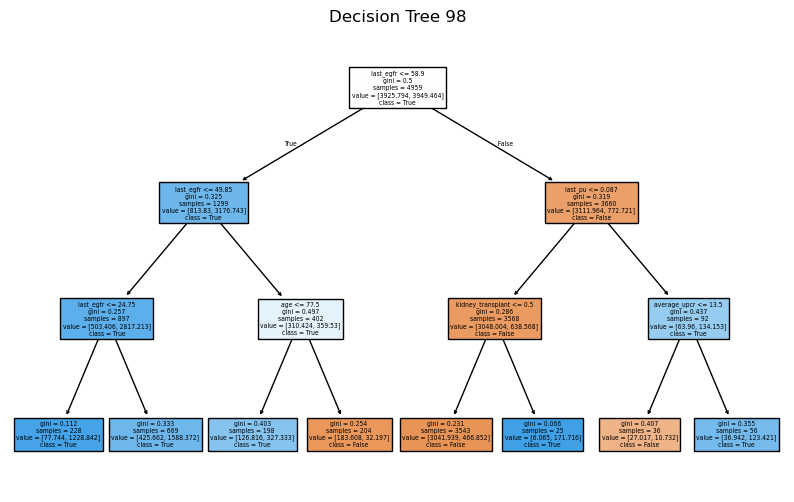

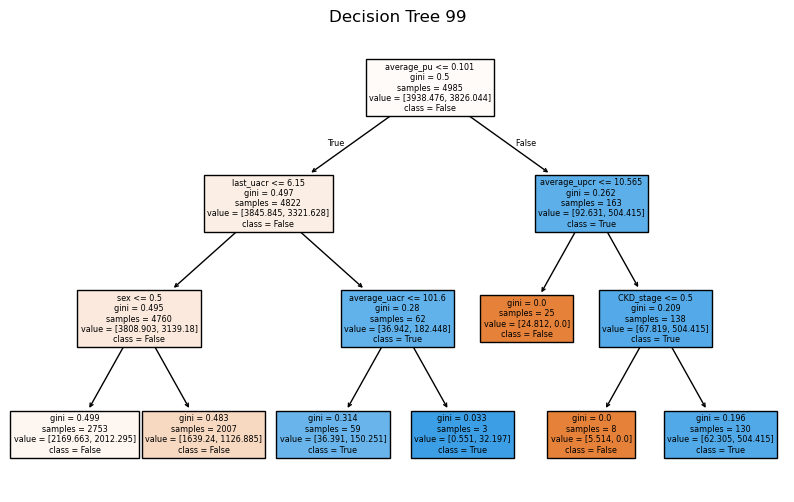

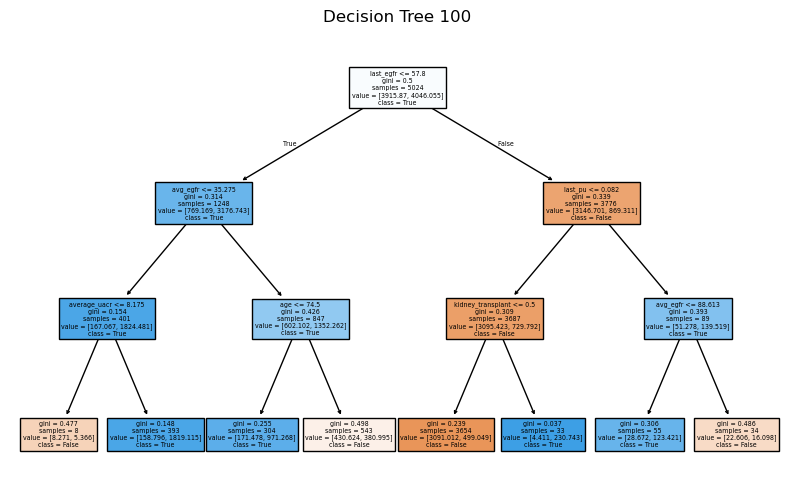

In [114]:
for i, tree in enumerate(clf.estimators_):
    plt.figure(figsize=(10, 6))
    plot_tree(tree, filled=True, feature_names=X_train.columns, class_names=["False", "True"])
    plt.title(f"Decision Tree {i+1}")
    plt.show()

In [ ]:
def test_models(X_train, X_val, y_train, y_val):
    param_grid = {
    'criterion': ['friedman_mse'],
    # 'criterion': ['squared_error', 'friedman_mse', 'absolute_error'],
    # 'min_samples_split': range(3,8),
    # 'min_samples_leaf': range(1,5)
    }
    param_comb = ParameterGrid(param_grid)

    best_rmse = float("inf")
    best_params = None
    best_depth = None
    best_n_estimators = None
    best_max_samples = None

    rmses = []
    best_reg = None

    # n_estimators, max_samples, max_depth
    for tqdm(n_estim in range(10, 100, 10)):
        for depth in range(2, 6):
            for param in param_comb:
                clf = RandomForestClassifier(n_estimators=n_estim, max_depth=depth, **param)
                clf.fit(X_train, y_train)
                rmse = root_mean_squared_error(clf.predict(X_val), y_val)
                if(rmse < best_rmse):
                    best_depth = depth
                    best_n_estimators = n_estim
                    best_params = param
                    best_rmse = rmse
                    rmses.append(rmse)
                    best_clf = clf



    print(f"best_rmse: {best_rmse}")
    print(f"best_depth: {best_depth}")
    print(f"best_n_estimators: {best_n_estimators}")
    print(f"best_params: {best_params}")

    return best_rmse, best_depth, best_n_estimators, best_params, rmses, best_clf